# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>


## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project.    
**`project_title`**    | Title of the project.  
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: 
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> 
  **`school_state`** | State where school is located ([Two-letter U.S. postal code]
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. 
**`project_resource_summary`** | An explanation of the resources needed for the project. 
**`project_essay_1`**    | First application essay  
**`project_essay_2`**    | Second application essay 
**`project_essay_3`**    | Third application essay
**`project_essay_4`**    | Fourth application essay
**`project_submitted_datetime`** | Datetime when project application was submitted.    
**`teacher_id`** | A unique identifier for the teacher of the proposed project.   
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher.  

<br>

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file. 
**`description`** | Desciption of the resource. 
**`quantity`** | Quantity of the resource required.   
**`price`** | Price of the resource required. 


The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.<br>

Source: https://www.kaggle.com/c/donorschoose-application-screening/data


## Declaration:

For the purpose of this project, we have used help from various online resources for help in understanding some concepts, intuition about the code flow, Debugging the various errors, etc.

Wherever possible we have credited all the resources in their respective sections.

Some of the frequently used resources include:
<ul>
<li>StackOverflow (and its variants)
<li>Notebooks shared by Applied AI.
<li>Towards Data Science Blogs
<li>machinelearningmastery.com
<li>Medium Blogs
<li>Kaggle

</ul>

We have tried to include as many resources that we have used, but in all possibiliy we may have missed many.
We profusely apologize to any other authors for using your resouces and content but failing to appropriately credit you.

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [ ]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [ ]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [ ]:
#here we are trying to convert the datatype of project_submitted_datetime column to datetime. Originally the dtype of this 
#column is Object. And after this it becomes datetime64[ns]. we are also changing the column name to 'Date'

# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [ ]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [ ]:
#merging the two dataframes
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

  project_subject_categories            project_subject_subcategories  \
0             Math & Science  Applied Sciences, Health & Life Science   
1              Special Needs                            Special Needs   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  Most of my students have autism, anxiety, anot...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                            53                    1  725.05   
1                                             4                    1  213.03   

   quantity  
0         4  
1         8

## 1.2 Preprocessing 

### 1.2.1 Preprocessing of `project_subject_categories`

In [ ]:
print(project_data.columns)
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)



Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')


In [ ]:
#now we are sorting the categories based on number of occurences in the corpus
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


### 1.2.2 Preprocessing of `project_subject_subcategories`

In [ ]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing 

Checking if any if the columns have nan entries or not

In [ ]:
#https://stackoverflow.com/a/26266451/8488076
print(project_data.isna().sum())

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
Date                                                 0
project_grade_category                               0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
price                                                0
quantity                                             0
clean_categories                                     0
clean_subc

Since teacher_prefix column has 3 nan values then it is better to drop those rows.

In [ ]:
#https://stackoverflow.com/a/23235618/8488076
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]
print("The shape of the dataframe after dropping the rows is: ",project_data.shape)

The shape of the dataframe after dropping the rows is:  (109245, 19)


### 1.3.1 Text preprocessing of essays

In [ ]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [ ]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  Most of my students have autism, anxiety, anot...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                            53                    1  725.05   
1                                             4                    1  213.03   

   quantity clean_categories                 clean_subcategories  \
0         4     Math_Science  AppliedSciences Health_LifeScience   
1         8     SpecialNeeds                        SpecialNeeds   

                                               essay  
0  I have been fortunate enough to use the Fairy ...  
1  Imagine being 8-9 years old. You're in your th...

In [ ]:
# printing some random essays
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

Some of my students come from difficult family lives, but they do not let that stop them. We have built a community in our classroom that allows each student to be comfortable with who they are. Even though we are a diverse school, everyone feels included. We have a high Hispanic population, and about 90% of the students are on free or reduced-price lunch. Most students are living with a single parent or both parents work full time, although many parents are eager to help in any way they can.\r\nWe all know how important it is to get kids up and moving. I want my classroom to be a place where students can be active phyically and mentally. The requested items will allow my students to move all day. When they are sitting in a chair, their movement is limited.\r\n       Kindergarten students have a hard time sitting still for long periods of time. They would much rather bounce on a stability ball or wiggle on a cushion than sit in a hard chair. Having these choices in my classroom will al

In [ ]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Some of my students come from difficult family lives, but they do not let that stop them. We have built a community in our classroom that allows each student to be comfortable with who they are. Even though we are a diverse school, everyone feels included. We have a high Hispanic population, and about 90% of the students are on free or reduced-price lunch. Most students are living with a single parent or both parents work full time, although many parents are eager to help in any way they can.  We all know how important it is to get kids up and moving. I want my classroom to be a place where students can be active phyically and mentally. The requested items will allow my students to move all day. When they are sitting in a chair, their movement is limited.         Kindergarten students have a hard time sitting still for long periods of time. They would much rather bounce on a stability ball or wiggle on a cushion than sit in a hard chair. Having these choices in my classroom will allow 

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Some of my students come from difficult family lives but they do not let that stop them We have built a community in our classroom that allows each student to be comfortable with who they are Even though we are a diverse school everyone feels included We have a high Hispanic population and about 90 of the students are on free or reduced price lunch Most students are living with a single parent or both parents work full time although many parents are eager to help in any way they can We all know how important it is to get kids up and moving I want my classroom to be a place where students can be active phyically and mentally The requested items will allow my students to move all day When they are sitting in a chair their movement is limited Kindergarten students have a hard time sitting still for long periods of time They would much rather bounce on a stability ball or wiggle on a cushion than sit in a hard chair Having these choices in my classroom will allow students to be active and 

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Combining all the above statements 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109245/109245 [01:22<00:00, 1320.82it/s]


In [ ]:
# after preprocesing
preprocessed_essays[20000]


'students come difficult family lives not let stop built community classroom allows student comfortable even though diverse school everyone feels included high hispanic population 90 students free reduced price lunch students living single parent parents work full time although many parents eager help way know important get kids moving want classroom place students active phyically mentally requested items allow students move day sitting chair movement limited kindergarten students hard time sitting still long periods time would much rather bounce stability ball wiggle cushion sit hard chair choices classroom allow students active learn time choices classroom also build greater bond students learn choose seat best fits learning style hopefully able help classmates find seat works students move around room able work everyone instead one group day nannan'

<h3>1.3.2 Text Preprocessing of `project_title`</h3>

In [ ]:
# printing some random titles
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[99999])
print("="*50)


Engineering STEAM into the Primary Classroom
Building Blocks for Learning
Empowering Students Through Art:Learning About Then and Now
Wiggle While We Learn
Area Architect!


In [ ]:
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:02<00:00, 40233.98it/s]


In [ ]:
# after preprocesing
preprocessed_titles[20000]

'wiggle learn'

### 1.3.3 Preprocessing 'teacher_prefix'

In [ ]:
preprocessed_prefix = []
for prefix in tqdm(project_data['teacher_prefix'].values):
    sent = decontracted(prefix)
    sent = sent.replace('\\r',' ')
    sent = sent.replace('\\n',' ')
    sent = sent.replace('\\"',' ')
    sent = re.sub('[^A-Za-z0-9]+',' ',sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_prefix.append(sent.lower().strip())
    

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:01<00:00, 66954.23it/s]


In [ ]:
print("Before preprocessing: ")
print(project_data['teacher_prefix'].unique())
print("-"*50)
print("After preprocessing: ")
temp = set(preprocessed_prefix)
print(temp)

Before preprocessing: 
['Mrs.' 'Ms.' 'Mr.' 'Teacher' 'Dr.']
--------------------------------------------------
After preprocessing: 
{'mrs', 'mr', 'dr', 'ms', 'teacher'}


In [ ]:
#inserting the processed prefixes in the dataframe
project_data['clean_prefix'] = preprocessed_prefix
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  ...  \
0  My students come from a variety of backgrounds...  ...   
1  Most of my students have autism, anxiety, anot...  ...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                           53                    1  725.05   
1                                            4                    1  213.03   

   quantity  clean_categories                 clean_subcategories  \
0         4      Math_Science  AppliedSciences Health_LifeScience   
1         8      SpecialNeeds                        SpecialNeeds   

                                               essay clean_prefix  
0  I have been fortunate enough to use the Fairy ...          mrs  
1  Imagine being 8-9 years old. You're in your th...           ms  

[2 rows x 21 columns]

### 1.3.4 Preprocessing 'project_grade_category'

In [ ]:
preprocessed_grades = []
for grade in tqdm(project_data['project_grade_category'].values):
    sent = decontracted(grade)
    sent = sent.replace('\\r',' ')
    sent = sent.replace('\\n',' ')
    sent = sent.replace('\\"',' ')
    sent = re.sub('[^A-Za-z0-9]+',' ',sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    final = ''
    for i in sent.split():
        final=final+i
    preprocessed_grades.append(final.lower().strip())
    

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:02<00:00, 43235.30it/s]


In [ ]:
print("Before preprocessing: ")
print(project_data['project_grade_category'].unique())
print("-"*50)
print("After preprocessing: ")
temp = set(preprocessed_grades)
print(temp)


Before preprocessing: 
['Grades PreK-2' 'Grades 3-5' 'Grades 9-12' 'Grades 6-8']
--------------------------------------------------
After preprocessing: 
{'grades912', 'grades68', 'grades35', 'gradesprek2'}


In [ ]:
#inserting the processed grades in the data frame
project_data['clean_grades'] = preprocessed_grades
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  ...  \
0  My students come from a variety of backgrounds...  ...   
1  Most of my students have autism, anxiety, anot...  ...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects project_is_approved   price  \
0                                           53                   1  725.05   
1                                            4                   1  213.03   

   quantity  clean_categories                 clean_subcategories  \
0         4      Math_Science  AppliedSciences Health_LifeScience   
1         8      SpecialNeeds                        SpecialNeeds   

                                               essay clean_prefix clean_grades  
0  I have been fortunate enough to use the Fairy ...          mrs  gradesprek2  
1  Imagine being 8-9 years old. You're in your th...           ms     grades35  

[2 rows x 22 columns]

## 1.4 Preparing data for models

In [ ]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories', 'essay',
       'clean_prefix', 'clean_grades'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

In [ ]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer.fit_transform(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)
temp = categories_one_hot.toarray()
print(temp[0:5])

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109245, 9)
[[0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]]


In [ ]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer.fit_transform(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)
temp = sub_categories_one_hot.toarray()
print(temp[0:5])

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109245, 30)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [ ]:
#https://stackoverflow.com/a/52405012/8488076
import scipy
state_list = project_data['school_state'].unique()
vectorizer = CountVectorizer(vocabulary = state_list,lowercase=False,binary=True )
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_one_hot.shape)
print(scipy.sparse.issparse(school_state_one_hot))
temp=school_state_one_hot.toarray()
print(temp[0:5])


['CA', 'UT', 'GA', 'WA', 'HI', 'IL', 'OH', 'KY', 'SC', 'FL', 'MO', 'MI', 'NY', 'VA', 'MD', 'TX', 'MS', 'NJ', 'AZ', 'OK', 'PA', 'WV', 'NC', 'CO', 'DC', 'MA', 'ID', 'AL', 'ME', 'TN', 'IN', 'LA', 'CT', 'AR', 'KS', 'OR', 'WI', 'IA', 'SD', 'AK', 'MN', 'NM', 'NV', 'MT', 'RI', 'NH', 'WY', 'NE', 'DE', 'ND', 'VT']
Shape of matrix after one hot encoding  (109245, 51)
True
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
vectorizer.fit(project_data['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot = vectorizer.transform(project_data['clean_prefix'].values)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot.shape)
temp = teacher_prefix_one_hot.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encoding  (109245, 5)
[[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
vectorizer.fit(project_data['clean_grades'].values)
print(vectorizer.get_feature_names())

grade_category_one_hot = vectorizer.transform(project_data['clean_grades'].values)
print("Shape of matrix after one hot encoding ",grade_category_one_hot.shape)
temp = grade_category_one_hot.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of matrix after one hot encoding  (109245, 4)
[[0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]]


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [ ]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109245, 16512)


In [ ]:
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("shape of matrix after bow ",title_bow.shape)

shape of matrix after bow  (109245, 3222)


#### 1.4.2.2 TFIDF vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109245, 16512)


In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after tfidf ",title_tfidf.shape)

Shape of matrix after tfidf  (109245, 3222)


#### 1.4.2.3 Using Pretrained Models: Avg W2V

In [ ]:
# storing and retrieving variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 109245/109245 [00:31<00:00, 3455.03it/s]


109245
300


In [ ]:
avg_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title.append(vector)

print(len(avg_w2v_title))
print(len(avg_w2v_title[0]))

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:01<00:00, 67467.25it/s]


109245
300


#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109245/109245 [03:54<00:00, 465.65it/s]


109245
300


In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title.append(vector)

print(len(tfidf_w2v_title))
print(len(tfidf_w2v_title[0]))

100%|███████████████████████████████████████████████████████████████████████| 109245/109245 [00:03<00:00, 28026.28it/s]


109245
300


### 1.4.3 Vectorizing Numerical features

In [ ]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1152448166964, Standard deviation : 367.49642545627506


In [ ]:
price_standardized

array([[ 1.16173852],
       [-0.23152673],
       [ 0.08404097],
       ...,
       [ 0.27451901],
       [-0.02825944],
       [-0.7962397 ]])

In [ ]:
num_pro_scaler = StandardScaler()
num_pro_scaler.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {num_pro_scaler.mean_[0]}, Standard deviation : {np.sqrt(num_pro_scaler.var_[0])}")

num_pro_standardized = num_pro_scaler.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 11.153462401025218, Standard deviation : 27.77734982798095


C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [ ]:
num_pro_standardized

array([[ 1.50649856],
       [-0.25752861],
       [-0.04152529],
       ...,
       [-0.40153083],
       [-0.36553028],
       [-0.32952972]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [ ]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(grade_category_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)
print(num_pro_standardized.shape)

(109245, 9)
(109245, 30)
(109245, 51)
(109245, 5)
(109245, 4)
(109245, 16512)
(109245, 1)
(109245, 1)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109245, 16552)

# Part 1: Apply KNN

<h1>2. K Nearest Neighbor</h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
#choosing the first 100K values for performing KNN
new_data = project_data.head(100000)
new_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2     ...       \
0  My students come from a variety of backgrounds...     ...        
1  Most of my students have autism, anxiety, anot...     ...        

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects project_is_approved   price  \
0                                           53                   1  725.05   
1                                            4                   1  213.03   

   quantity  clean_categories                 clean_subcategories  \
0         4      Math_Science  AppliedSciences Health_LifeScience   
1         8      SpecialNeeds                        SpecialNeeds   

                                               essay clean_prefix clean_grades  
0  I have been fortunate enough to use the Fairy ...          mrs  gradesprek2  
1  Imagine being 8-9 years old. You're in your th...           ms     grades35  

[2 rows x 22 columns]

In [ ]:
print(new_data.columns)
y = new_data['project_is_approved'].values
X = new_data.drop(['project_is_approved'], axis=1)
X.head(1)


Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories', 'essay',
       'clean_prefix', 'clean_grades'],
      dtype='object')


Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   

                                     project_essay_2     ...       \
0  My students come from a variety of backgrounds...     ...        

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   

  teacher_number_of_previously_posted_projects   price  quantity  \
0                                           53  725.05         4   

   clean_categories                 clean_subcategories  \
0      Math_Science  AppliedSciences Health_LifeScience   

                                               essay clean_prefix clean_grades  
0  I have been fortunate enough to use the Fairy ...          mrs  gradesprek2  

[1 rows x 21 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
<h3>2.2.1 Encoding the categorical features</h3>

The categorical features being considered are:
1. teacher_prefix
2. school_state
3. project_grade_category
4. clean_categories
5. clean_sub_categories

<h4> 2.2.1.1 Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (44890, 5)
Shape of cv matrix after one hot encoding  (22110, 5)
Shape of test matrix after one hot encoding  (33000, 5)
--------------------------------------------------
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


<h4> 2.2.1.2 Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (44890, 51)
Shape of cv matrix after one hot encoding  (22110, 51)
Shape of test matrix after one hot encoding  (33000, 51)
--------------------------------------------------
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

#### 2.2.1.3 Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (44890, 4)
Shape of cv matrix after one hot encoding  (22110, 4)
Shape of test matrix after one hot encoding  (33000, 4)
--------------------------------------------------
[[0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]


#### 2.2.1.4 Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (44890, 9)
Shape of cv matrix after one hot encoding  (22110, 9)
Shape of test matrix after one hot encoding  (33000, 9)
--------------------------------------------------
[[0 0 0 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 0 0]]


#### 2.2.1.5 Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (44890, 30)
Shape of cv matrix after one hot encoding  (22110, 30)
Shape of test matrix after one hot encoding  (33000, 30)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 

### 2.2.2 Encoding numerical features

The numerical features considered are:
1. teacher_number_of_previously_posted_projects
2. price

#### 2.2.2.1 Encoding 'price' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 300.9582684339496, Standard deviation : 369.79079934867156


In [ ]:
print(price_standardized_train[0:5])
print("-"*50)
print(price_standardized_cv[0:5])
print("-"*50)
print(price_standardized_test[0:5])
print("-"*50)

[[-0.78414138]
 [-0.78822477]
 [-0.50230635]
 [-0.00272659]
 [-0.68151579]]
--------------------------------------------------
[[-0.5542276 ]
 [ 1.61724341]
 [ 0.41415777]
 [-0.77735376]
 [ 0.03167124]]
--------------------------------------------------
[[-0.6921975 ]
 [-0.28142471]
 [ 0.40301633]
 [-0.20286678]
 [ 0.23473199]]
--------------------------------------------------


#### 2.2.2.2 Encoding 'teacher_number_of_previously_posted_projects' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


numpro_scalar = StandardScaler()
numpro_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {numpro_scalar.mean_[0]}, Standard deviation : {np.sqrt(numpro_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
numpro_standardized_train = numpro_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_cv = numpro_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_test = numpro_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 10.8500556916908, Standard deviation : 27.366406392075568


C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\safik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [ ]:
print(numpro_standardized_train[0:5])
print("-"*50)
print(numpro_standardized_cv[0:5])
print("-"*50)
print(numpro_standardized_test[0:5])
print("-"*50)

[[-0.39647353]
 [-0.39647353]
 [-0.28685007]
 [-0.35993238]
 [-0.39647353]]
--------------------------------------------------
[[ 1.02863138]
 [ 0.04202029]
 [-0.25030892]
 [-0.35993238]
 [-0.35993238]]
--------------------------------------------------
[[-0.35993238]
 [-0.39647353]
 [-0.14068547]
 [-0.35993238]
 [-0.39647353]]
--------------------------------------------------


<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
### 2.3.1 Text preprocessing

#### 2.3.1.1 Essays

In [ ]:
# for test data
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 44890/44890 [00:27<00:00, 1607.56it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 22110/22110 [00:13<00:00, 1635.83it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [00:20<00:00, 1602.36it/s]


#### 2.3.1.2 project_title

In [ ]:
# for test data
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 44890/44890 [00:01<00:00, 32267.13it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 22110/22110 [00:00<00:00, 33961.85it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 33000/33000 [00:00<00:00, 35073.59it/s]


### 2.3.2 Vectorizing Essays

#### 2.3.2.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_essays_train)
text_bow_train= vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after BOW ",text_bow_train.shape)

Shape of matrix after BOW  (44890, 11622)


In [ ]:
#for cv data
text_bow_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after BOW ",text_bow_cv.shape)

Shape of matrix after BOW  (22110, 11622)


In [ ]:
#for test data
text_bow_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after BOW ",text_bow_test.shape)

Shape of matrix after BOW  (33000, 11622)


#### 2.3.2.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after tfidf vectorization ",text_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (44890, 11622)


In [ ]:
#for cv data
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after tfidf vectorization ",text_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (22110, 11622)


In [ ]:
#for test data
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after tfidf vectorization ",text_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (33000, 11622)


#### 2.3.2.3 Avg W2V

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#for train data
avg_w2v_vectors_train = [];
for sentence in tqdm(preprocessed_essays_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 44890/44890 [00:13<00:00, 3218.08it/s]


44890
300


In [ ]:
#for cv data
avg_w2v_vectors_cv = [];
for sentence in tqdm(preprocessed_essays_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 22110/22110 [00:06<00:00, 3271.47it/s]


22110
300


In [ ]:
#for test data
avg_w2v_vectors_test = [];
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [00:10<00:00, 3222.29it/s]


33000
300


#### 2.3.2.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 44890/44890 [01:36<00:00, 465.39it/s]


44890
300


In [ ]:
#for cv data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_cv)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_cv = []; 
for sentence in tqdm(preprocessed_essays_cv): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22110/22110 [00:50<00:00, 439.54it/s]


22110
300


In [ ]:
#for test data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_test)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_test = []; 
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 33000/33000 [01:12<00:00, 457.43it/s]


33000
300


### 2.3.3 Vectorizing project_titles

#### 2.3.3.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_bow_train= vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after BOW ",title_bow_train.shape)

Shape of matrix after BOW  (44890, 1888)


In [ ]:
#for cv data
title_bow_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after BOW ",title_bow_cv.shape)

Shape of matrix after BOW  (22110, 1888)


In [ ]:
#for test data
title_bow_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after BOW ",title_bow_test.shape)

Shape of matrix after BOW  (33000, 1888)


#### 2.3.3.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after tfidf vectorization ",title_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (44890, 1888)


In [ ]:
#for cv data
title_tfidf_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after tfidf vectorization ",title_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (22110, 1888)


In [ ]:
#for test data
title_tfidf_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after tfidf vectorization ",title_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (33000, 1888)


#### 2.3.3.3 Avg W2V

In [ ]:
#for train data
avg_w2v_title_train = [];
for sentence in tqdm(preprocessed_titles_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)

print(len(avg_w2v_title_train))
print(len(avg_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 44890/44890 [00:00<00:00, 60986.33it/s]


44890
300


In [ ]:
#for cv data
avg_w2v_title_cv = [];
for sentence in tqdm(preprocessed_titles_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_cv.append(vector)

print(len(avg_w2v_title_cv))
print(len(avg_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22110/22110 [00:00<00:00, 58028.48it/s]


22110
300


In [ ]:
#for test data
avg_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)

print(len(avg_w2v_title_test))
print(len(avg_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33000/33000 [00:00<00:00, 61116.13it/s]


33000
300


#### 2.3.3.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_train = []; 
for sentence in tqdm(preprocessed_titles_train): 
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 44890/44890 [00:01<00:00, 28213.15it/s]


44890
300


In [ ]:
#for cv data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_cv)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_cv = []; 
for sentence in tqdm(preprocessed_titles_cv): 
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 22110/22110 [00:00<00:00, 28308.45it/s]


22110
300


In [ ]:
#for test data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_test)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33000/33000 [00:01<00:00, 28847.51it/s]


33000
300


<h2>2.4 Appling KNN on different kind of featurization </h2>



In [ ]:
I. For set 1 we are using categorical features,numerical features, project_title(BOW) and project_essay(BOW)<br>
II. For set 2 we are using categorical features,numerical features, project_title(tfidf) and project_essay(tfidf)<br>
III. For set 3 we are using categorical features,numerical features, project_title(avg W2V) and project_essay(avg W2V)<br>
IV. For set 4 we are using categorical features,numerical features, project_title(tfidf W2V) and project_essay(tfidf W2V)<br>

In [ ]:
First we are forming the data matrices of train, cv and test by concatinating the individual matrices of categorical and numerical data 

In [ ]:
from scipy.sparse import hstack
cat_num_train = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_standardized_train,price_standardized_train))
print(cat_num_train.shape)
print("="*50)
cat_num_cv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_standardized_cv,price_standardized_cv))
print(cat_num_cv.shape)
print("="*50)
cat_num_test = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_standardized_test,price_standardized_test))
print(cat_num_test.shape)

(44890, 101)
(22110, 101)
(33000, 101)


### 2.4.1 Applying KNN brute force on BOW - SET 1

Forming the final data matrix using titles and essays encoded by Bag of Words technique

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_bow_train,text_bow_train)).tocsr()
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_bow_cv,text_bow_cv)).tocsr()
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_bow_test,text_bow_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (44890, 13611) (44890,)
CV data  (22110, 13611) (22110,)
Test data  (33000, 13611) (33000,)


Performing <b>Hyperparameter Tuning</b>

In [ ]:
#The code is taken from the Assignment_SAMPLE_SOLUTION.ipynb shared by AppliedAI
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 1/5 [04:20<17:20, 260.21s/it]

 40%|█████████████████████████████████▏                                                 | 2/5 [08:52<13:09, 263.30s/it]

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [13:21<08:50, 265.24s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [17:47<04:25, 265.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [22:14<00:00, 266.22s/it]



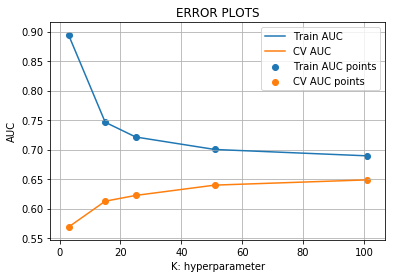

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(new_Xtrain, y_train)

    y_train_pred = batch_predict(neigh, new_Xtrain)    
    y_cv_pred = batch_predict(neigh, new_Xcv)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

<b>Analysis:</b> By observing the above AUC vs K plot we can observe that the curve for CV data is not tending ti increase considerably after k=80.  So since the value of AUC must be high. Therefore choosing k to be 90.<br>
<b> K = 95 </b>

<b>Testing the performance</b>

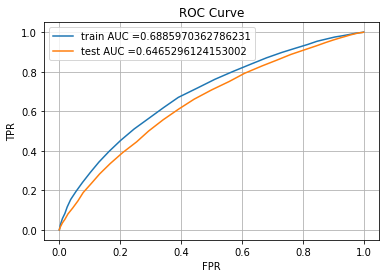

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

best_k = 95
neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(new_Xtrain, y_train)

y_train_pred = batch_predict(neigh, new_Xtrain)    
y_test_pred = batch_predict(neigh, new_Xtest)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

The AUC score for test data is 0.64 which is better than 0.5 i.e score for a random model. 

Finding the <b>Confusion Matrix</b>

In [ ]:
#The code is taken from Assignment_SAMPLE_SOLUTION.ipynb by AppliedAI
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4083141442683521 for threshold 0.789


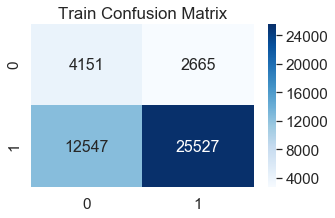

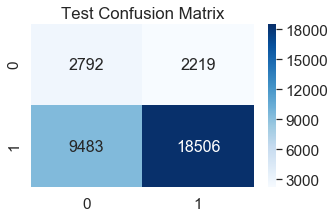

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.2 Applying KNN brute force on TFIDF -  SET 2

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_tfidf_train,text_tfidf_train)).tocsr()
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_tfidf_cv,text_tfidf_cv)).tocsr()
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_tfidf_test,text_tfidf_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (44890, 13611) (44890,)
CV data  (22110, 13611) (22110,)
Test data  (33000, 13611) (33000,)


Performing <b>Hyperparameter tuning</b>



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 1/5 [04:25<17:41, 265.46s/it]

 40%|█████████████████████████████████▏                                                 | 2/5 [08:48<13:13, 264.54s/it]

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [13:17<08:51, 265.99s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [17:41<04:25, 265.54s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [22:06<00:00, 265.31s/it]



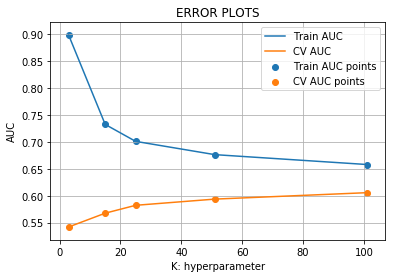

In [ ]:
# Please write all the code with proper documentation
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(new_Xtrain, y_train)

    y_train_pred = batch_predict(neigh, new_Xtrain)    
    y_cv_pred = batch_predict(neigh, new_Xcv)
 
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

<b>Analysis:</b> By observing the above plot we observe that the AUC score is nearly becoming constant as K increases.
Therefor choosing k as 101<br>
<b> K = 101

<b> Testing the performance </b>

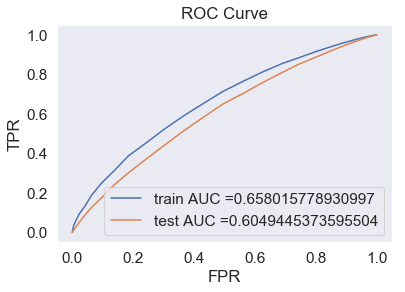

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as pl

best_k = 101
neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(new_Xtrain, y_train)

y_train_pred = batch_predict(neigh, new_Xtrain)    
y_test_pred = batch_predict(neigh, new_Xtest)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

pl.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
pl.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
pl.legend()
pl.xlabel("FPR")
pl.ylabel("TPR")
pl.title("ROC Curve")
pl.grid()
pl.show()

We observe that the AUC score for test data is 0.604 which is better than 0.5 i.e, random model.

Finding the <b>Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.3741483874619255 for threshold 0.851


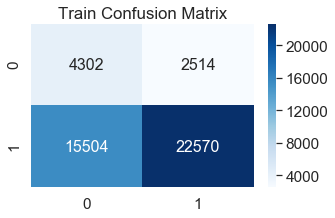

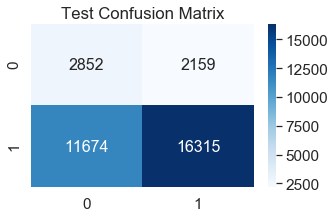

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.3 Applying KNN brute force on AVG W2V -  SET 3

In [ ]:
# Please write all the code with proper documentation
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,avg_w2v_title_train,avg_w2v_vectors_train)).tocsr()
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,avg_w2v_title_cv,avg_w2v_vectors_cv)).tocsr()
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,avg_w2v_title_test,avg_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (44890, 701) (44890,)
CV data  (22110, 701) (22110,)
Test data  (33000, 701) (33000,)


Performing <b>Hyperparameter Tuning</b>



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▎                                                                  | 1/6 [34:55<2:54:31, 2094.39s/it]

 33%|██████████████████████████                                                    | 2/6 [1:10:52<2:20:53, 2113.34s/it]

 50%|███████████████████████████████████████                                       | 3/6 [1:46:55<1:46:24, 2128.25s/it]

 67%|████████████████████████████████████████████████████                          | 4/6 [2:23:36<1:11:39, 2149.93s/it]

 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [2:59:58<35:59, 2159.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [3:36:14<00:00, 2164.27s/it]



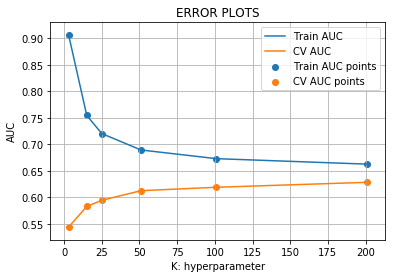

In [ ]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101,201]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(new_Xtrain, y_train)

    y_train_pred = batch_predict(neigh, new_Xtrain)    
    y_cv_pred = batch_predict(neigh, new_Xcv)
 
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

<b>Analysis:</b> Since from the above plot we can observe that there is not much change in the AUC values from 100 to 200. So to reduce the time of execution taking K as 101.<br>
<b>K = 101</b>

<b>Testing the performance</b>

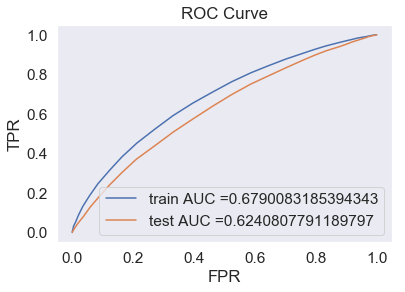

In [ ]:
from sklearn.metrics import roc_curve, auc

best_k = 101
neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(new_Xtrain, y_train)

y_train_pred = batch_predict(neigh, new_Xtrain)    
y_test_pred = batch_predict(neigh, new_Xtest)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

The obtained AUC score for test data is 0.624 which is better than 0.5 i.e, Random model

Finding the <b>Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.3952274585863309 for threshold 0.861


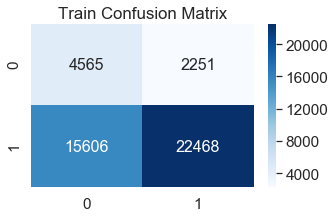

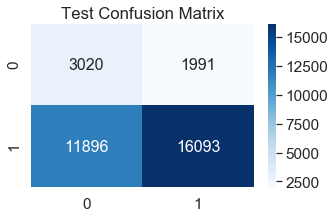

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.4 Applying KNN brute force on TFIDF W2V -  SET 4

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,tfidf_w2v_title_train,tfidf_w2v_vectors_train)).tocsr()
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,tfidf_w2v_title_cv,tfidf_w2v_vectors_cv)).tocsr()
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,tfidf_w2v_title_test,tfidf_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (44890, 701) (44890,)
CV data  (22110, 701) (22110,)
Test data  (33000, 701) (33000,)


Performing <b>Hyperparameter Tuning</b>



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████                                                                | 1/5 [35:58<2:23:48, 2157.16s/it]

 40%|███████████████████████████████▏                                              | 2/5 [1:12:10<1:48:04, 2161.46s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [1:49:25<1:12:46, 2183.45s/it]

 80%|████████████████████████████████████████████████████████████████                | 4/5 [2:25:43<36:22, 2182.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:01:40<00:00, 2174.54s/it]



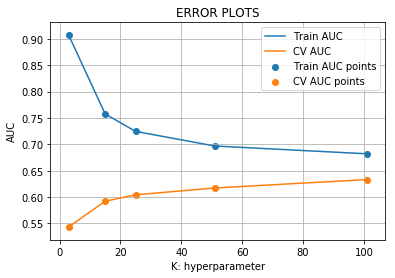

In [ ]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(new_Xtrain, y_train)

    y_train_pred = batch_predict(neigh, new_Xtrain)    
    y_cv_pred = batch_predict(neigh, new_Xcv)
 
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

<b>Analysis:</b> After observing the above plot we can take K as above 100 say 105.<br>
<b> K = 105</b>


<b>Testing the performance</b>

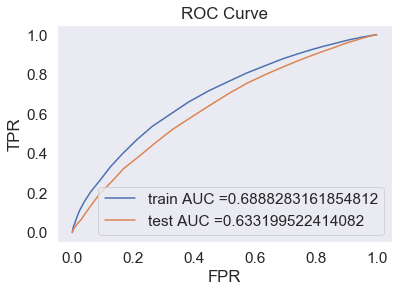

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

best_k = 105
neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(new_Xtrain, y_train)

y_train_pred = batch_predict(neigh, new_Xtrain)    
y_test_pred = batch_predict(neigh, new_Xtest)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

From the above plot we can say that the AUC score is 0.633

Finding the <b>Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.4076924051531969 for threshold 0.848


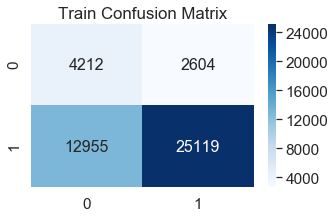

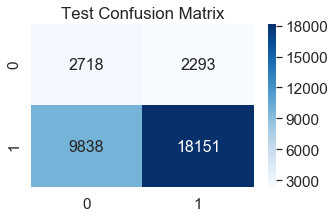

In [ ]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h1>3. Conclusions</h1>

In [ ]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Vectorizing Technique","Hyperparameter","AUC Score"]
x.add_row(["BOW",95,0.64])
x.add_row(["TFIDF",101,0.604])
x.add_row(["Avg W2V",101,0.624])
x.add_row(["TFIDF W2V",105,0.633])
print(x)

+-----------------------+----------------+-----------+
| Vectorizing Technique | Hyperparameter | AUC Score |
+-----------------------+----------------+-----------+
|          BOW          |       95       |    0.64   |
|         TFIDF         |      101       |   0.604   |
|        Avg W2V        |      101       |   0.624   |
|       TFIDF W2V       |      105       |   0.633   |
+-----------------------+----------------+-----------+


The above table compares the various vetorizing techniques where for our data set we get a highest AUC score of 0.64 by following the BOW technique and K Nearest Neighbors

# Part 2 : Logistic Regression

<h1>2. Logistic Regression </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
print(project_data.columns)
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)


Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'clean_prefix',
       'clean_grades', 'price', 'quantity'],
      dtype='object')


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   

  teacher_number_of_previously_posted_projects   clean_categories  \
0                                            0  Literacy_Language   

  clean_subcategories                                              essay  \
0        ESL Literacy  My students are English learners that are work...   

  clean_prefix clean_grades  price  quantity  
0          mrs  gradesprek2  154.6        23  

[1 rows x 21 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
<h3>2.2.1 Encoding the categorical features</h3>

The categorical features being considered are:
1. teacher_prefix
2. school_state
3. project_grade_category
4. clean_categories
5. clean_sub_categories

<h4> 2.2.1.1 Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (49039, 5)
Shape of cv matrix after one hot encoding  (24155, 5)
Shape of test matrix after one hot encoding  (36051, 5)
--------------------------------------------------
[[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


<h4> 2.2.1.2 Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (49039, 51)
Shape of cv matrix after one hot encoding  (24155, 51)
Shape of test matrix after one hot encoding  (36051, 51)
--------------------------------------------------
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

#### 2.2.1.3 Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (49039, 4)
Shape of cv matrix after one hot encoding  (24155, 4)
Shape of test matrix after one hot encoding  (36051, 4)
--------------------------------------------------
[[0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


#### 2.2.1.4 Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 9)
Shape of cv matrix after one hot encoding  (24155, 9)
Shape of test matrix after one hot encoding  (36051, 9)
--------------------------------------------------
[[0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


#### 2.2.1.5 Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 30)
Shape of cv matrix after one hot encoding  (24155, 30)
Shape of test matrix after one hot encoding  (36051, 30)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 

### 2.2.2 Encoding numerical features

The numerical features considered are:
1. teacher_number_of_previously_posted_projects
2. price

#### 2.2.2.1 Encoding 'price' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.4488447969983, Standard deviation : 369.87269187875955


In [ ]:
print(price_standardized_train[0:5])
print("-"*50)
print(price_standardized_cv[0:5])
print("-"*50)
print(price_standardized_test[0:5])
print("-"*50)

[[ 0.33717319]
 [ 0.00411265]
 [-0.77988684]
 [-0.6910725 ]
 [-0.77610175]]
--------------------------------------------------
[[-0.78799774]
 [ 4.03641898]
 [ 0.86943741]
 [ 1.49113781]
 [-0.49819532]]
--------------------------------------------------
[[ 1.23975402]
 [ 0.36726462]
 [-0.38910373]
 [-0.51747222]
 [ 0.46637981]]
--------------------------------------------------


#### 2.2.2.2 Encoding 'teacher_number_of_previously_posted_projects' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


numpro_scalar = StandardScaler()
numpro_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {numpro_scalar.mean_[0]}, Standard deviation : {np.sqrt(numpro_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
numpro_standardized_train = numpro_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_cv = numpro_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_test = numpro_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


Mean : 11.142131772670732, Standard deviation : 27.64400362886996


In [ ]:
print(numpro_standardized_train[0:5])
print("-"*50)
print(numpro_standardized_cv[0:5])
print("-"*50)
print(numpro_standardized_test[0:5])
print("-"*50)

[[-0.22218677]
 [-0.11366414]
 [ 0.06720692]
 [-0.29453519]
 [-0.29453519]]
--------------------------------------------------
[[-0.40305782]
 [-0.18601256]
 [-0.40305782]
 [-0.40305782]
 [ 0.21190376]]
--------------------------------------------------
[[-0.40305782]
 [-0.40305782]
 [ 1.98444006]
 [-0.36688361]
 [ 0.7183427 ]]
--------------------------------------------------


<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
### 2.3.1 Text preprocessing

#### 2.3.1.1 Essays

In [ ]:
# for train data
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:26<00:00, 1858.49it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:12<00:00, 1870.67it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:19<00:00, 1864.23it/s]


#### 2.3.1.2 project_title

In [ ]:
# for test data
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 40636.50it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 40363.99it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 40796.97it/s]


### 2.3.2 Vectorizing Essays

#### 2.3.2.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_bow_train= vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after BOW ",text_bow_train.shape)

Shape of matrix after BOW  (49039, 5000)


In [ ]:
#for cv data
text_bow_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after BOW ",text_bow_cv.shape)

Shape of matrix after BOW  (24155, 5000)


In [ ]:
#for test data
text_bow_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after BOW ",text_bow_test.shape)

Shape of matrix after BOW  (36051, 5000)


#### 2.3.2.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after tfidf vectorization ",text_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 5000)


In [ ]:
#for cv data
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after tfidf vectorization ",text_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 5000)


In [ ]:
#for test data
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after tfidf vectorization ",text_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 5000)


#### 2.3.2.3 Avg W2V

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#for train data
avg_w2v_vectors_train = [];
for sentence in tqdm(preprocessed_essays_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:13<00:00, 3737.18it/s]


49039
300


In [ ]:
#for cv data
avg_w2v_vectors_cv = [];
for sentence in tqdm(preprocessed_essays_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:06<00:00, 3722.08it/s]


24155
300


In [ ]:
#for test data
avg_w2v_vectors_test = [];
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:09<00:00, 3756.75it/s]


36051
300


#### 2.3.2.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49039/49039 [01:31<00:00, 534.18it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_vectors_cv = []; 
for sentence in tqdm(preprocessed_essays_cv): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [00:45<00:00, 535.96it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_vectors_test = []; 
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36051/36051 [01:07<00:00, 533.97it/s]


36051
300


### 2.3.3 Vectorizing project_titles

#### 2.3.3.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_bow_train= vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after BOW ",title_bow_train.shape)

Shape of matrix after BOW  (49039, 1993)


In [ ]:
#for cv data
title_bow_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after BOW ",title_bow_cv.shape)

Shape of matrix after BOW  (24155, 1993)


In [ ]:
#for test data
title_bow_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after BOW ",title_bow_test.shape)

Shape of matrix after BOW  (36051, 1993)


#### 2.3.3.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after tfidf vectorization ",title_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 1993)


In [ ]:
#for cv data
title_tfidf_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after tfidf vectorization ",title_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 1993)


In [ ]:
#for test data
title_tfidf_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after tfidf vectorization ",title_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 1993)


#### 2.3.3.3 Avg W2V

In [ ]:
#for train data
avg_w2v_title_train = [];
for sentence in tqdm(preprocessed_titles_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)

print(len(avg_w2v_title_train))
print(len(avg_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:00<00:00, 72202.80it/s]


49039
300


In [ ]:
#for cv data
avg_w2v_title_cv = [];
for sentence in tqdm(preprocessed_titles_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_cv.append(vector)

print(len(avg_w2v_title_cv))
print(len(avg_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 73384.94it/s]


24155
300


In [ ]:
#for test data
avg_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)

print(len(avg_w2v_title_test))
print(len(avg_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 75146.26it/s]


36051
300


#### 2.3.3.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_train = []; 
for sentence in tqdm(preprocessed_titles_train): 
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 37649.43it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_title_cv = []; 
for sentence in tqdm(preprocessed_titles_cv): 
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 37608.09it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 36847.54it/s]


36051
300


<h2>2.4 Appling Logistic Regression on different kind of featurization </h2>



I. For set 1 we are using categorical features,numerical features, project_title(BOW) and project_essay(BOW)<br>
II. For set 2 we are using categorical features,numerical features, project_title(tfidf) and project_essay(tfidf)<br>
III. For set 3 we are using categorical features,numerical features, project_title(avg W2V) and project_essay(avg W2V)<br>
IV. For set 4 we are using categorical features,numerical features, project_title(tfidf W2V) and project_essay(tfidf W2V)<br>

First we are forming the data matrices of train, cv and test by concatinating the individual matrices of categorical and numerical data

In [ ]:
from scipy.sparse import hstack
cat_num_train = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_standardized_train,price_standardized_train))
print(cat_num_train.shape)
print("="*50)
cat_num_cv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_standardized_cv,price_standardized_cv))
print(cat_num_cv.shape)
print("="*50)
cat_num_test = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_standardized_test,price_standardized_test))
print(cat_num_test.shape)

(49039, 101)
(24155, 101)
(36051, 101)


### 2.4.1 Applying Logistic Regression on SET-1

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_bow_train,text_bow_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_bow_cv,text_bow_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_bow_test,text_bow_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 7094) (49039,)
CV data  (24155, 7094) (24155,)
Test data  (36051, 7094) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 7094)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                0.0001],
                          'class_weight': ['balanced']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [ ]:
model.cv_results_

{'mean_fit_time': array([48.56945531, 35.50538929, 25.75313433, 15.47362224,  7.67647235,
         3.51792574,  1.389949  ,  0.81847803,  0.46542096]),
 'std_fit_time': array([4.27304277, 1.54844751, 1.61208181, 0.36974401, 0.16184074,
        0.16488799, 0.01493344, 0.01084407, 0.04072713]),
 'mean_score_time': array([0.01296576, 0.02493366, 0.01529304, 0.0196143 , 0.01662262,
        0.0126334 , 0.01363047, 0.01396267, 0.01130295]),
 'std_score_time': array([0.00081391, 0.01553611, 0.00470095, 0.01011615, 0.0065821 ,
        0.00047025, 0.00094066, 0.00141063, 0.00047002]),
 'param_C': masked_array(data=[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

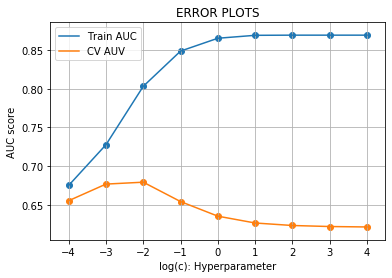

In [ ]:
#plotting the error plots
newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(c): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is highest at log_10(c) = -2 i.e., <b>c = 0.01</b>. It can also be oberved from the previous cell where we did model.best_estimator_.

Testing the <b> Performance</b>

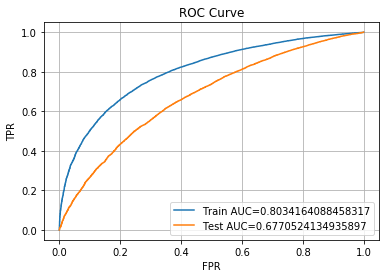

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

best_c = 0.01
model = LogisticRegression(C=0.01,n_jobs=-1,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.677 which is better than a random model.

Finding <b> Confusion Matrix</b>

In [ ]:
#The code is taken from Assignment_SAMPLE_SOLUTION.ipynb by AppliedAI
import numpy as np
import pandas as pd
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.5361325790546726 for threshold 0.488


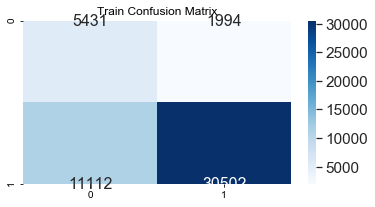

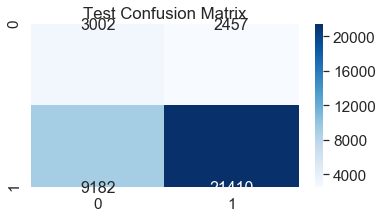

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.transforms


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (6,3))
plt.title("Train Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt = 'g',cmap='Blues')
plt.show()

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (6,3))
plt.title("Test Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g',cmap='Blues')
plt.show()

### 2.4.2 Applying Logistic Regression on SET-2

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_tfidf_train,text_tfidf_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_tfidf_cv,text_tfidf_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_tfidf_test,text_tfidf_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 7094) (49039,)
CV data  (24155, 7094) (24155,)
Test data  (36051, 7094) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 7094)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                0.0001],
                          'class_weight': ['balanced']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [ ]:
model.cv_results_

{'mean_fit_time': array([74.51441113, 51.84369993, 24.8173031 , 12.61925467,  6.32907605,
         2.78721372,  1.38197104,  0.77127067,  0.39859939]),
 'std_fit_time': array([4.0083691 , 3.18986251, 3.46328479, 0.32024866, 0.04886505,
        0.03568546, 0.04356646, 0.02821304, 0.08869051]),
 'mean_score_time': array([0.01496077, 0.01263301, 0.02593168, 0.01595799, 0.0172871 ,
        0.01728678, 0.01396275, 0.01728694, 0.01595712]),
 'std_score_time': array([0.00282097, 0.00047013, 0.01101613, 0.0037321 , 0.00554359,
        0.00611348, 0.00215523, 0.00752293, 0.00705201]),
 'param_C': masked_array(data=[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

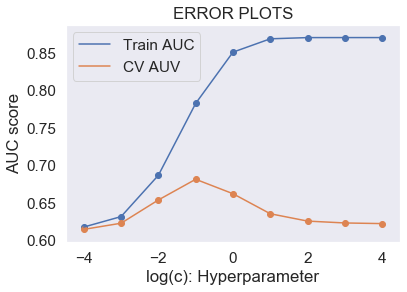

In [ ]:
#plotting the error plots
newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(c): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(c) = -1 i.e., <b>c = 0.1</b>. It can also be oberved from the previous cell where we did model.best_estimator_.

Testing the <b> Performance</b>

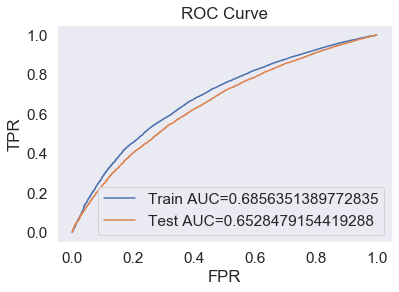

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

best_c = 0.1
model = LogisticRegression(C=0.01,n_jobs=-1,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.652 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.40847191901068003 for threshold 0.494


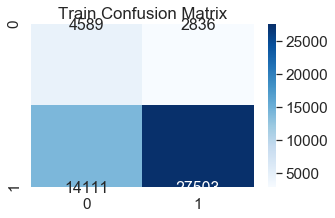

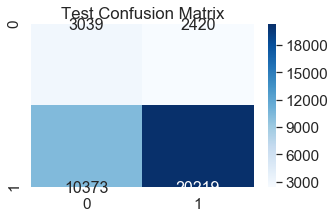

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.3 Applying Logistic Regression on SET-3

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,avg_w2v_title_train,avg_w2v_vectors_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,avg_w2v_title_cv,avg_w2v_vectors_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,avg_w2v_title_test,avg_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 701) (49039,)
CV data  (24155, 701) (24155,)
Test data  (36051, 701) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 701)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                0.0001],
                          'class_weight': ['balanced']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [ ]:
model.cv_results_

{'mean_fit_time': array([121.7760299 , 117.65837351, 116.83457589,  91.33609366,
         59.16046643,  28.79998557,  13.22895718,   6.60666529,
          3.54219302]),
 'std_fit_time': array([3.93714205, 4.88487063, 1.76516935, 1.36828719, 5.55421502,
        3.48294584, 0.570486  , 0.11612634, 0.37541785]),
 'mean_score_time': array([0.0784572 , 0.08577092, 0.07679518, 0.0794549 , 0.08277885,
        0.07280564, 0.06981397, 0.06316495, 0.05352386]),
 'std_score_time': array([0.0087829 , 0.01229561, 0.0085019 , 0.01316393, 0.00508539,
        0.01199585, 0.01232239, 0.00339045, 0.00529853]),
 'param_C': masked_array(data=[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
   

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

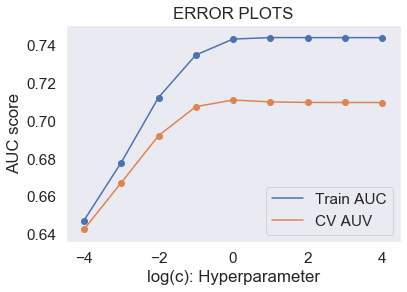

In [ ]:
#plotting the error plots
newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(c): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(c) = 0 i.e., <b>c = 1</b>. It can also be oberved from the previous cell where we did model.best_estimator_.

Testing the <b> Performance</b>

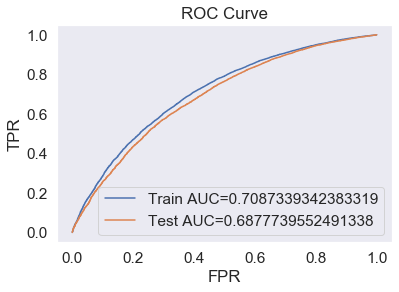

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

best_c = 1
model = LogisticRegression(C=0.01,n_jobs=-1,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.687 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.42905618884087665 for threshold 0.486


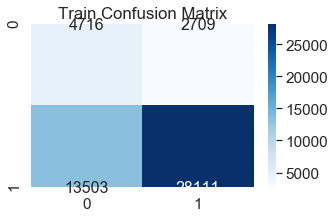

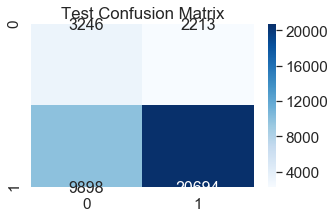

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.4 Applying Logistic Regression on SET-4

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,tfidf_w2v_title_train,tfidf_w2v_vectors_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,tfidf_w2v_title_cv,tfidf_w2v_vectors_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,tfidf_w2v_title_test,tfidf_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 701) (49039,)
CV data  (24155, 701) (24155,)
Test data  (36051, 701) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 701)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                0.0001],
                          'class_weight': ['balanced']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [ ]:
model.cv_results_

{'mean_fit_time': array([67.32928912, 67.74251715, 67.2129333 , 67.44198767, 48.72769801,
        29.05430532, 12.37025309,  6.22801145,  3.31014752]),
 'std_fit_time': array([5.13851335, 5.62112492, 5.40244538, 5.28323563, 1.56811415,
        1.41965271, 0.09853622, 0.52665592, 0.69692998]),
 'mean_score_time': array([0.08078424, 0.07513285, 0.07180858, 0.07347059, 0.0694809 ,
        0.06781904, 0.06050555, 0.05585138, 0.04953456]),
 'std_score_time': array([0.01419852, 0.00692591, 0.00407158, 0.00124433, 0.01246612,
        0.00695753, 0.00870718, 0.00570056, 0.00339045]),
 'param_C': masked_array(data=[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

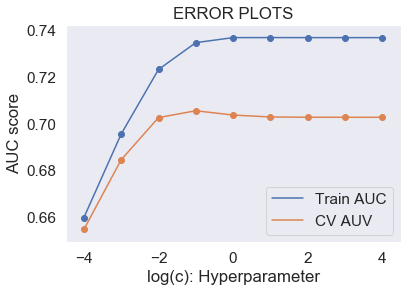

In [ ]:
#plotting the error plots
newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(c): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(c) = -1 i.e., <b>c = 0.1</b>. It can also be oberved from the previous cell where we did model.best_estimator_.

Testing the <b> Performance</b>

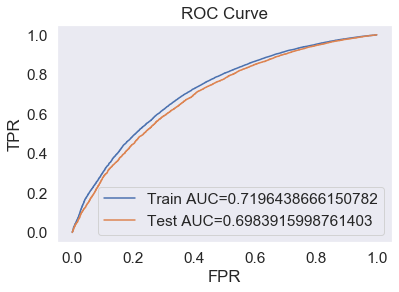

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

best_c = 0.1
model = LogisticRegression(C=0.01,n_jobs=-1,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.698 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.4421193560377489 for threshold 0.478


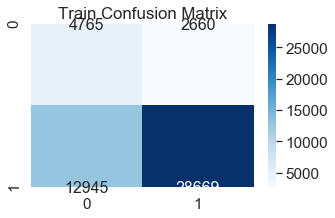

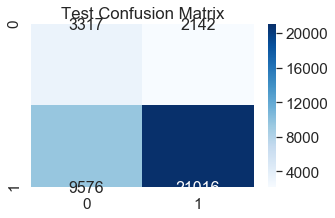

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h2>2.5 Logistic Regression with added Feature 'Sentiment score of each essay' </h2>

In [ ]:
Consider these set of features Set 5 :<br>
<B>school_state</B> : categorical data<br>
<B>clean_categories</B> : categorical data<br>
<B>clean_subcategories</B> : categorical data<br>
<B>project_grade_category</B> :categorical data<br>
<B>teacher_prefix</B> : categorical data<br>
<B>quantity</B> : numerical data<br>
<B>teacher_number_of_previously_posted_projects</B> : numerical data<br>
<B>price</B> : numerical data<br>
<B>sentiment score's of each of the essay</B> : numerical data<br>
<B>number of words in the title </B>: numerical data<br>
<B>number of words in the combine essays</B> : numerical data<br>


In [ ]:
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                            0                   0   
1                                            7                   1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay clean_prefix  \
0  My students are English learners that are work...          mrs   
1  Our students arrive to our school eager to lea...           mr   

  clean_grades  price quantity  
0  gradesprek2  154.6       23  
1     grades68  299.0        1  

[2 rows x 22 columns]

In [ ]:
#calculating no of words in the title
num_words_title = []
for i in project_data['project_title']:
    j=i.split()
    tlen = len(j)
    num_words_title.append(tlen)
project_data['num_words_title']=num_words_title

In [ ]:
#calculating the no of words in essay
#https://stackoverflow.com/a/37483537/8488076
num_words_essay = project_data['essay'].str.split().apply(len)
num_words_essay = list(num_words_essay)
project_data['num_words_essay'] = num_words_essay


In [ ]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_is_approved  \
0  \"The limits of your language are the limits o...  ...                   0   
1  The projector we need for our school is very c...  ...                   1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  clean_prefix  \
0  My students are English learners that are work...           mrs   
1  Our students arrive to our school eager to lea...            mr   

  clean_grades  price quantity num_words_title num_words_essay  
0  gradesprek2  154.6       23               7             272  
1     grades68  299.0        1               5             221  

[2 rows x 24 columns]

<b>Calculating sentiment scores</b>

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
sentiment_score = []
for i in project_data['essay']:
    for_sentiment = i;
    ss = sid.polarity_scores(for_sentiment)
    comp_Score = ss['compound']
    sentiment_score.append(comp_Score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...


In [ ]:
project_data['sentiment_score']=sentiment_score
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  clean_prefix  \
0  My students are English learners that are work...           mrs   
1  Our students arrive to our school eager to lea...            mr   

   clean_grades  price quantity num_words_title num_words_essay  \
0   gradesprek2  154.6       23               7             272   
1      grades68  299.0        1               5             221   

  sentiment_score  
0          0.9611  
1          0.9267  

[2 rows x 25 columns]

<h3> Stratified splitting of data

In [ ]:
project_data.columns
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ...   clean_categories  \
0  \"The limits of your language are the limits o...  ...  Literacy_Language   

  clean_subcategories                                              essay  \
0        ESL Literacy  My students are English learners that are work...   

   clean_prefix clean_grades  price quantity num_words_title num_words_essay  \
0           mrs  gradesprek2  154.6       23               7             272   

   sentiment_score  
0           0.9611  

[1 rows x 24 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h3>Encoding Categorical features

<h4> Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (49039, 5)
Shape of cv matrix after one hot encoding  (24155, 5)
Shape of test matrix after one hot encoding  (36051, 5)
--------------------------------------------------
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]


<h4>  Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (49039, 51)
Shape of cv matrix after one hot encoding  (24155, 51)
Shape of test matrix after one hot encoding  (36051, 51)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

####  Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (49039, 4)
Shape of cv matrix after one hot encoding  (24155, 4)
Shape of test matrix after one hot encoding  (36051, 4)
--------------------------------------------------
[[0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]]


#### Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 9)
Shape of cv matrix after one hot encoding  (24155, 9)
Shape of test matrix after one hot encoding  (36051, 9)
--------------------------------------------------
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 0 0]]


####  Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 30)
Shape of cv matrix after one hot encoding  (24155, 30)
Shape of test matrix after one hot encoding  (36051, 30)
--------------------------------------------------
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 

<H3> Encoding numerical features

####  Encoding 'price' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 296.6071434980322, Standard deviation : 361.4352732706222


In [ ]:
print(price_standardized_train[0:5])
print("-"*50)
print(price_standardized_cv[0:5])
print("-"*50)
print(price_standardized_test[0:5])
print("-"*50)

[[ 0.40854578]
 [-0.43384571]
 [-0.2728487 ]
 [-0.68232727]
 [-0.55500157]]
--------------------------------------------------
[[ 1.9831569 ]
 [ 1.1074261 ]
 [-0.23964773]
 [-0.40565256]
 [ 0.74769364]]
--------------------------------------------------
[[-0.51092729]
 [ 0.33719137]
 [-0.32751962]
 [ 1.38426682]
 [ 0.16750677]]
--------------------------------------------------


#### Encoding 'teacher_number_of_previously_posted_projects' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


numpro_scalar = StandardScaler()
numpro_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {numpro_scalar.mean_[0]}, Standard deviation : {np.sqrt(numpro_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
numpro_standardized_train = numpro_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_cv = numpro_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_test = numpro_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


Mean : 11.331776749118049, Standard deviation : 28.364696477957715


In [ ]:
print(numpro_standardized_train[0:5])
print("-"*50)
print(numpro_standardized_cv[0:5])
print("-"*50)
print(numpro_standardized_test[0:5])
print("-"*50)

[[-0.36424775]
 [-0.39950284]
 [-0.25848247]
 [-0.39950284]
 [ 0.58763975]]
--------------------------------------------------
[[-0.25848247]
 [-0.39950284]
 [-0.29373756]
 [-0.15271719]
 [-0.32899265]]
--------------------------------------------------
[[-0.1174621 ]
 [-0.22322738]
 [-0.39950284]
 [-0.04695191]
 [ 0.16457864]]
--------------------------------------------------


<h4> Encoding Quantity for train, cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


quant_scalar = StandardScaler()
quant_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quant_scalar.mean_[0]}, Standard deviation : {np.sqrt(quant_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quant_standardized_train = quant_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
quant_standardized_cv = quant_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
quant_standardized_test = quant_scalar.transform(X_test['quantity'].values.reshape(-1, 1))


Mean : 16.994575745834947, Standard deviation : 26.477814604454565


In [ ]:
print(quant_standardized_train[0:5])
print("-"*50)
print(quant_standardized_cv[0:5])
print("-"*50)
print(quant_standardized_test[0:5])
print("-"*50)

[[-0.22639994]
 [ 0.64225181]
 [ 0.71778674]
 [-0.33970235]
 [-0.49077222]]
--------------------------------------------------
[[ 4.11685881]
 [ 2.94606732]
 [-0.56630715]
 [-0.60407462]
 [-0.41523728]]
--------------------------------------------------
[[-0.03756261]
 [-0.18863248]
 [-0.41523728]
 [-0.15086501]
 [-0.56630715]]
--------------------------------------------------


<h4>Encoding sentiment_score for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


senti_scalar = StandardScaler()
senti_scalar.fit(X_train['sentiment_score'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {senti_scalar.mean_[0]}, Standard deviation : {np.sqrt(senti_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
senti_standardized_train = senti_scalar.transform(X_train['sentiment_score'].values.reshape(-1, 1))
senti_standardized_cv = senti_scalar.transform(X_cv['sentiment_score'].values.reshape(-1, 1))
senti_standardized_test = senti_scalar.transform(X_test['sentiment_score'].values.reshape(-1, 1))


Mean : 0.9610737311119721, Standard deviation : 0.14603504763499767


In [ ]:
print(senti_standardized_train[0:5])
print("-"*50)
print(senti_standardized_cv[0:5])
print("-"*50)
print(senti_standardized_test[0:5])
print("-"*50)

[[-0.15046889]
 [ 0.22204443]
 [ 0.20903385]
 [ 0.09330821]
 [ 0.21108816]]
--------------------------------------------------
[[ 0.25354372]
 [ 0.17753457]
 [ 0.19054514]
 [-0.04501475]
 [ 0.05564602]]
--------------------------------------------------
[[-1.31183393]
 [-0.0751445 ]
 [ 0.2268378 ]
 [ 0.19191468]
 [ 0.22820733]]
--------------------------------------------------


<h4>Encoding num_words_title for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


titlew_scalar = StandardScaler()
titlew_scalar.fit(X_train['num_words_title'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {titlew_scalar.mean_[0]}, Standard deviation : {np.sqrt(titlew_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
titlew_standardized_train = titlew_scalar.transform(X_train['num_words_title'].values.reshape(-1, 1))
titlew_standardized_cv = titlew_scalar.transform(X_cv['num_words_title'].values.reshape(-1, 1))
titlew_standardized_test = titlew_scalar.transform(X_test['num_words_title'].values.reshape(-1, 1))

Mean : 5.150879911906849, Standard deviation : 2.1074282162129196


In [ ]:
print(titlew_standardized_train[0:5])
print("-"*50)
print(titlew_standardized_cv[0:5])
print("-"*50)
print(titlew_standardized_test[0:5])
print("-"*50)

[[-0.54610634]
 [ 1.82645371]
 [-0.07159433]
 [-0.54610634]
 [-0.54610634]]
--------------------------------------------------
[[ 0.40291768]
 [ 1.82645371]
 [-0.07159433]
 [-0.07159433]
 [-0.07159433]]
--------------------------------------------------
[[-0.07159433]
 [-1.02061835]
 [-0.54610634]
 [-0.54610634]
 [-1.02061835]]
--------------------------------------------------


<h4>Encoding num_words_essay for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


essayw_scalar = StandardScaler()
essayw_scalar.fit(X_train['num_words_essay'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {essayw_scalar.mean_[0]}, Standard deviation : {np.sqrt(essayw_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
essayw_standardized_train = essayw_scalar.transform(X_train['num_words_essay'].values.reshape(-1, 1))
essayw_standardized_cv = essayw_scalar.transform(X_cv['num_words_essay'].values.reshape(-1, 1))
essayw_standardized_test = essayw_scalar.transform(X_test['num_words_essay'].values.reshape(-1, 1))

Mean : 255.04575949754278, Standard deviation : 65.41113979340305


In [ ]:
print(essayw_standardized_train[0:5])
print("-"*50)
print(essayw_standardized_cv[0:5])
print("-"*50)
print(essayw_standardized_test[0:5])
print("-"*50)

[[-0.93326243]
 [-0.47462496]
 [ 0.33563458]
 [-0.45933704]
 [-0.44404913]]
--------------------------------------------------
[[ 1.39050077]
 [ 1.74212284]
 [ 0.0604521 ]
 [ 0.07574001]
 [-0.42876121]]
--------------------------------------------------
[[ 0.18275542]
 [-1.14729326]
 [ 0.09102793]
 [ 1.45165244]
 [-0.84153494]]
--------------------------------------------------


<b>Combining all the features together to form a data matrix</b>

In [ ]:
from scipy.sparse import hstack
new_Xtrain = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_standardized_train,price_standardized_train,quant_standardized_train,titlew_standardized_train,essayw_standardized_train,senti_standardized_train))
print(new_Xtrain.shape)
print("="*50)
new_Xcv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_standardized_cv,price_standardized_cv,quant_standardized_cv,titlew_standardized_cv,essayw_standardized_cv,senti_standardized_cv))
print(new_Xcv.shape)
print("="*50)
new_Xtest = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_standardized_test,price_standardized_test,quant_standardized_test,titlew_standardized_test,essayw_standardized_test,senti_standardized_test))
print(new_Xtest.shape)

(49039, 105)
(24155, 105)
(36051, 105)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 105)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                0.0001],
                          'class_weight': ['balanced']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [ ]:
model.cv_results_

{'mean_fit_time': array([1.633298  , 1.58575861, 1.5844295 , 1.54653001, 1.38695637,
        0.89194703, 0.50265463, 0.31648572, 0.16489188]),
 'std_fit_time': array([0.10256996, 0.05341784, 0.05215639, 0.06886787, 0.09433545,
        0.03292101, 0.02406018, 0.01108595, 0.01200627]),
 'mean_score_time': array([0.01030596, 0.00930858, 0.00930874, 0.00831183, 0.0089763 ,
        0.00864363, 0.01130358, 0.00864434, 0.0139629 ]),
 'std_score_time': array([0.00261693, 0.00124388, 0.00046974, 0.00047047, 0.00081381,
        0.00047019, 0.00235056, 0.00046935, 0.00533909]),
 'param_C': masked_array(data=[10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    'balanced

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

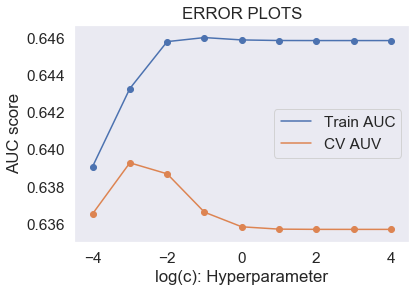

In [ ]:
#plotting the error plots
newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(c): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(c) = -3 i.e., <b>c = 0.001</b>. It can also be oberved from the previous cell where we did model.best_estimator_.

Testing the <b> Performance</b>

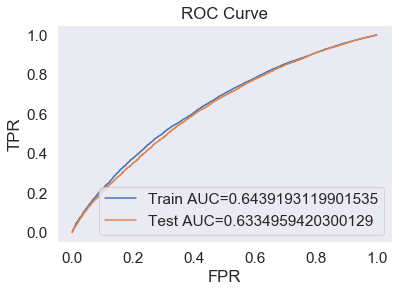

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

best_c = 0.001
model = LogisticRegression(C=0.01,n_jobs=-1,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.633 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.3652899835088522 for threshold 0.493


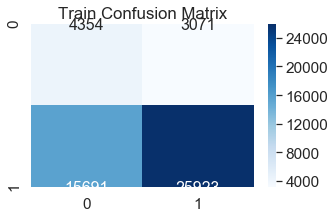

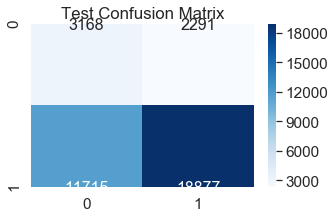

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')



conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h1>3. Conclusion</h1>

In [ ]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Vectorizing Technique","Hyperparameter","AUC Score"]
x.add_row(["BOW",0.01,0.677])
x.add_row(["TFIDF",0.1,0.652])
x.add_row(["Avg W2V",1,0.687])
x.add_row(["TFIDF W2V",0.1,0.698])
x.add_row(["No Text data",0.001,0.633])
print(x)

+-----------------------+----------------+-----------+
| Vectorizing Technique | Hyperparameter | AUC Score |
+-----------------------+----------------+-----------+
|          BOW          |      0.01      |   0.677   |
|         TFIDF         |      0.1       |   0.652   |
|        Avg W2V        |       1        |   0.687   |
|       TFIDF W2V       |      0.1       |   0.698   |
|      No Text data     |     0.001      |   0.633   |
+-----------------------+----------------+-----------+


# Part 3: SVM

<h1>2. Support Vector Machines </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
print(project_data.columns)
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)


Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'clean_prefix',
       'clean_grades', 'price', 'quantity'],
      dtype='object')


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   

  teacher_number_of_previously_posted_projects   clean_categories  \
0                                            0  Literacy_Language   

  clean_subcategories                                              essay  \
0        ESL Literacy  My students are English learners that are work...   

  clean_prefix clean_grades  price  quantity  
0          mrs  gradesprek2  154.6        23  

[1 rows x 21 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
<h3>2.2.1 Encoding the categorical features</h3>

The categorical features being considered are:
1. teacher_prefix
2. school_state
3. project_grade_category
4. clean_categories
5. clean_sub_categories

<h4> 2.2.1.1 Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (49039, 5)
Shape of cv matrix after one hot encoding  (24155, 5)
Shape of test matrix after one hot encoding  (36051, 5)
--------------------------------------------------
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]


<h4> 2.2.1.2 Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (49039, 51)
Shape of cv matrix after one hot encoding  (24155, 51)
Shape of test matrix after one hot encoding  (36051, 51)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

#### 2.2.1.3 Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (49039, 4)
Shape of cv matrix after one hot encoding  (24155, 4)
Shape of test matrix after one hot encoding  (36051, 4)
--------------------------------------------------
[[1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]]


#### 2.2.1.4 Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 9)
Shape of cv matrix after one hot encoding  (24155, 9)
Shape of test matrix after one hot encoding  (36051, 9)
--------------------------------------------------
[[1 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]]


#### 2.2.1.5 Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 30)
Shape of cv matrix after one hot encoding  (24155, 30)
Shape of test matrix after one hot encoding  (36051, 30)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 

### 2.2.2 Encoding numerical features

The numerical features considered are:
1. teacher_number_of_previously_posted_projects
2. price

#### 2.2.2.1 Encoding 'price' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.38412222924615, Standard deviation : 367.4745117726796


In [ ]:
print(price_standardized_train[0:5])
print("-"*50)
print(price_standardized_cv[0:5])
print("-"*50)
print(price_standardized_test[0:5])
print("-"*50)

[[-0.65009712]
 [-0.6596488 ]
 [ 0.81041234]
 [-0.26960815]
 [-0.33461946]]
--------------------------------------------------
[[ 0.68455327]
 [-0.2776087 ]
 [-0.60832552]
 [-0.47471081]
 [-0.69918896]]
--------------------------------------------------
[[ 0.25415607]
 [-0.05547085]
 [ 4.63054123]
 [ 0.00589395]
 [-0.01764509]]
--------------------------------------------------


#### 2.2.2.2 Encoding 'teacher_number_of_previously_posted_projects' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


numpro_scalar = StandardScaler()
numpro_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {numpro_scalar.mean_[0]}, Standard deviation : {np.sqrt(numpro_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
numpro_standardized_train = numpro_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_cv = numpro_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_test = numpro_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


Mean : 11.274149146597606, Standard deviation : 27.969531106928212


In [ ]:
print(numpro_standardized_train[0:5])
print("-"*50)
print(numpro_standardized_cv[0:5])
print("-"*50)
print(numpro_standardized_test[0:5])
print("-"*50)

[[-0.40308681]
 [-0.40308681]
 [-0.40308681]
 [ 0.31197702]
 [-0.36733362]]
--------------------------------------------------
[[-0.26007405]
 [-0.40308681]
 [-0.40308681]
 [-0.33158043]
 [-0.36733362]]
--------------------------------------------------
[[-0.40308681]
 [ 2.92195999]
 [-0.26007405]
 [ 0.56224936]
 [-0.40308681]]
--------------------------------------------------


<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
### 2.3.1 Text preprocessing

#### 2.3.1.1 Essays

In [ ]:
# for train data
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:25<00:00, 1914.35it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:12<00:00, 1940.45it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:18<00:00, 1941.77it/s]


#### 2.3.1.2 project_title

In [ ]:
# for test data
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 41806.45it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 41722.17it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 41941.61it/s]


### 2.3.2 Vectorizing Essays

#### 2.3.2.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_bow_train= vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after BOW ",text_bow_train.shape)

Shape of matrix after BOW  (49039, 5000)


In [ ]:
#for cv data
text_bow_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after BOW ",text_bow_cv.shape)

Shape of matrix after BOW  (24155, 5000)


In [ ]:
#for test data
text_bow_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after BOW ",text_bow_test.shape)

Shape of matrix after BOW  (36051, 5000)


#### 2.3.2.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after tfidf vectorization ",text_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 5000)


In [ ]:
#for cv data
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after tfidf vectorization ",text_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 5000)


In [ ]:
#for test data
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after tfidf vectorization ",text_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 5000)


#### 2.3.2.3 Avg W2V

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#for train data
avg_w2v_vectors_train = [];
for sentence in tqdm(preprocessed_essays_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:12<00:00, 3902.59it/s]


49039
300


In [ ]:
#for cv data
avg_w2v_vectors_cv = [];
for sentence in tqdm(preprocessed_essays_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:06<00:00, 3900.07it/s]


24155
300


In [ ]:
#for test data
avg_w2v_vectors_test = [];
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:09<00:00, 3901.98it/s]


36051
300


#### 2.3.2.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49039/49039 [01:25<00:00, 570.25it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_vectors_cv = []; 
for sentence in tqdm(preprocessed_essays_cv): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [00:42<00:00, 572.17it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_vectors_test = []; 
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36051/36051 [01:03<00:00, 567.47it/s]


36051
300


### 2.3.3 Vectorizing project_titles

#### 2.3.3.1 Bag of Words

In [ ]:
#for train data
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_bow_train= vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after BOW ",title_bow_train.shape)

Shape of matrix after BOW  (49039, 1983)


In [ ]:
#for cv data
title_bow_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after BOW ",title_bow_cv.shape)

Shape of matrix after BOW  (24155, 1983)


In [ ]:
#for test data
title_bow_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after BOW ",title_bow_test.shape)

Shape of matrix after BOW  (36051, 1983)


#### 2.3.3.2 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after tfidf vectorization ",title_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 1983)


In [ ]:
#for cv data
title_tfidf_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after tfidf vectorization ",title_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 1983)


In [ ]:
#for test data
title_tfidf_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after tfidf vectorization ",title_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 1983)


#### 2.3.3.3 Avg W2V

In [ ]:
#for train data
avg_w2v_title_train = [];
for sentence in tqdm(preprocessed_titles_train):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)

print(len(avg_w2v_title_train))
print(len(avg_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:00<00:00, 74079.85it/s]


49039
300


In [ ]:
#for cv data
avg_w2v_title_cv = [];
for sentence in tqdm(preprocessed_titles_cv):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_cv.append(vector)

print(len(avg_w2v_title_cv))
print(len(avg_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 80695.73it/s]


24155
300


In [ ]:
#for test data
avg_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)

print(len(avg_w2v_title_test))
print(len(avg_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 80497.81it/s]


36051
300


#### 2.3.3.4 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_train = []; 
for sentence in tqdm(preprocessed_titles_train): 
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 38319.08it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_title_cv = []; 
for sentence in tqdm(preprocessed_titles_cv): 
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 39583.47it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 38793.19it/s]


36051
300


<h2>2.4 Appling Support Vector Machines on different kind of featurization as mentioned in the below</h2>



I. For set 1 we are using categorical features,numerical features, project_title(BOW) and project_essay(BOW)<br>
II. For set 2 we are using categorical features,numerical features, project_title(tfidf) and project_essay(tfidf)<br>
III. For set 3 we are using categorical features,numerical features, project_title(avg W2V) and project_essay(avg W2V)<br>
IV. For set 4 we are using categorical features,numerical features, project_title(tfidf W2V) and project_essay(tfidf W2V)<br>

First we are forming the data matrices of train, cv and test by concatinating the individual matrices of categorical and numerical data

In [ ]:
from scipy.sparse import hstack
cat_num_train = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_standardized_train,price_standardized_train))
print(cat_num_train.shape)
print("="*50)
cat_num_cv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_standardized_cv,price_standardized_cv))
print(cat_num_cv.shape)
print("="*50)
cat_num_test = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_standardized_test,price_standardized_test))
print(cat_num_test.shape)

(49039, 101)
(24155, 101)
(36051, 101)


### 2.4.1 Applying SVM on SET-1

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_bow_train,text_bow_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_bow_cv,text_bow_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_bow_test,text_bow_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 7084) (49039,)
CV data  (24155, 7084) (24155,)
Test data  (36051, 7084) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 7084)
(73194,)


<b>Performing HyperParameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'alpha': [10**x for x in range(-4,5)],'class_weight':['balanced'],'penalty':['l2','l1']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                    10000],
                          'class_weight': ['balanced'],
                     

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 1.21340386, 10.17470805,  0.52831213,  2.42652313,  0.3021915 ,
         0.58875807,  0.1978035 ,  0.2206521 ,  0.15838178,  0.21869739,
         0.15621384,  0.20828422,  0.16926622,  0.23293567,  0.17317478,
         0.24322081,  0.16146747,  0.20455289]),
 'std_fit_time': array([2.96977943e-01, 9.70817310e-01, 7.37111168e-02, 5.87224110e-01,
        4.28116032e-02, 2.59787115e-01, 2.72679995e-02, 1.21603760e-02,
        6.29673031e-03, 1.27555204e-02, 4.49566384e-07, 7.36350400e-03,
        1.01768046e-02, 8.18346227e-03, 6.18749774e-03, 2.74509168e-02,
        5.04418771e-03, 4.43670250e-03]),
 'mean_score_time': array([0.01097035, 0.01218859, 0.0095288 , 0.010638  , 0.01030548,
        0.01030572, 0.01097067, 0.00631698, 0.        , 0.01041444,
        0.01041333, 0.00560578, 0.01518067, 0.00299199, 0.01263221,
        0.00864331, 0.00886353, 0.01019343]),
 'std_score_time': array([8.14685390e-04, 2.46113630e-03, 6.82453375e-03, 4.70527427e-04,
        4.

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

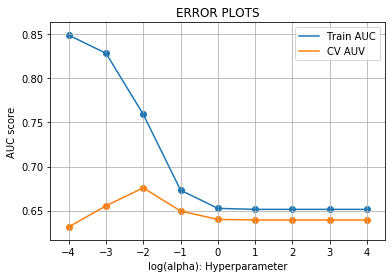

In [ ]:
#plotting the error plots
tuned_parameters = [{'alpha': [10**x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

newC = [np.log10(x) for x in [10**x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(alpha): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

From the above results and plot we can conclude that the ideal hyperparameter value is <b>alpha = 0.01</b> and the best regularizer is <b>'l2'</b>

Testing the <b> Performance</b>

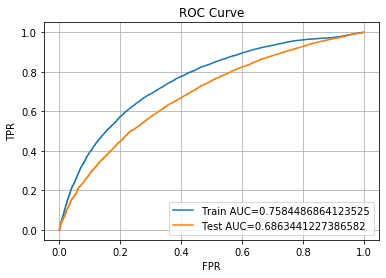

In [ ]:
#https://stackoverflow.com/a/56747024/8488076
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc

model = SGDClassifier(loss='hinge',alpha=0.01,n_jobs=-1,class_weight='balanced',penalty='l2')
model.fit(new_Xtrain,y_train)
y_train_pred = model.decision_function(new_Xtrain)
y_test_pred = model.decision_function(new_Xtest)

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

The AUC score obtained is <b>0.683</b>

Finding <b> Confusion Matrix</b>

In [ ]:
#The code is taken from Assignment_SAMPLE_SOLUTION.ipynb by AppliedAI
import numpy as np
import pandas as pd
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4832451912146245 for threshold -0.076


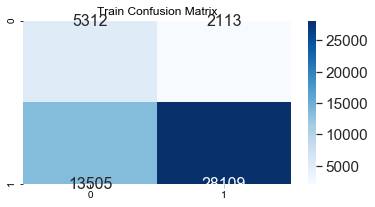

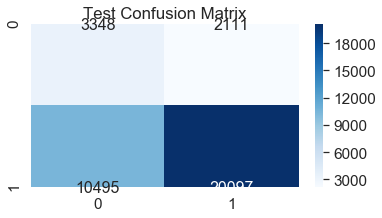

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.transforms


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (6,3))
plt.title("Train Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt = 'g',cmap='Blues')
plt.show()

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (6,3))
plt.title("Test Confusion Matrix")
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g',cmap='Blues')
plt.show()

### 2.4.2 Applying SVM on SET-2

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_tfidf_train,text_tfidf_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_tfidf_cv,text_tfidf_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_tfidf_test,text_tfidf_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 7084) (49039,)
CV data  (24155, 7084) (24155,)
Test data  (36051, 7084) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 7084)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced'],'penalty':['l2','l1']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                    0.0001],
                          'class_weight': ['balanced'],
                     

In [ ]:
model.cv_results_

{'mean_fit_time': array([0.15458751, 0.2473379 , 0.17985209, 0.22273612, 0.16821694,
        0.21209963, 0.15957308, 0.24534249, 0.17885439, 0.24102132,
        0.20245838, 0.21874762, 0.25166003, 0.37998311, 0.39494284,
        0.60936936, 0.7569747 , 1.28502464]),
 'std_fit_time': array([5.15042996e-07, 2.48469550e-02, 9.71560666e-03, 8.78207382e-03,
        9.40717679e-04, 3.29076171e-03, 3.73119099e-03, 1.49266756e-02,
        8.19705430e-03, 6.53211183e-03, 1.93903387e-02, 1.47777805e-02,
        4.90842859e-02, 6.15181307e-02, 1.05867547e-02, 1.04031528e-01,
        3.87890376e-02, 1.00431628e-01]),
 'mean_score_time': array([0.01063784, 0.01296568, 0.01163554, 0.00797868, 0.01163499,
        0.00831095, 0.01562444, 0.0089763 , 0.01828424, 0.01030612,
        0.01196758, 0.00831095, 0.01529304, 0.01196853, 0.01130335,
        0.01196822, 0.01097091, 0.00997416]),
 'std_score_time': array([4.70246438e-04, 6.36086494e-03, 9.39874767e-04, 8.14490792e-04,
        4.70302644e-04, 4.70

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

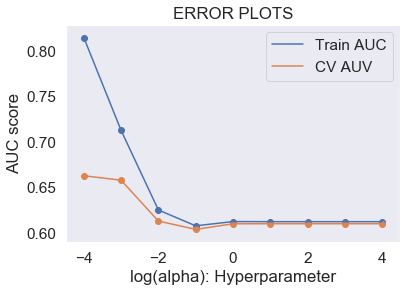

In [ ]:
#plotting the error plots
tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(alpha): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is highest at log_10(alpha) = -4 i.e., <b>c = 0.0001</b> and penalty = <b>'l1'</b>

Testing the <b> Performance</b>

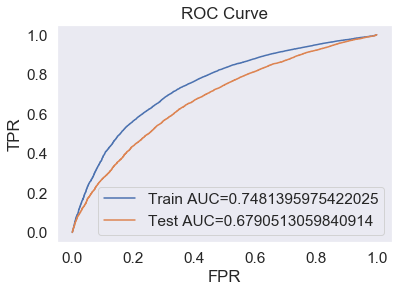

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc


model = SGDClassifier(alpha=0.0001,n_jobs=-1,class_weight='balanced',penalty='l1')
model.fit(new_Xtrain,y_train)
y_train_pred = model.decision_function(new_Xtrain)
y_test_pred = model.decision_function(new_Xtest)

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.679 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.47642476575239584 for threshold -0.087


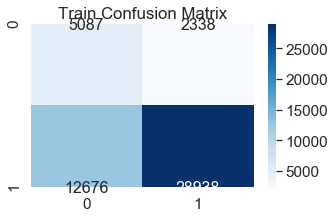

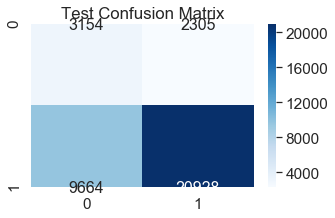

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.3 Applying SVM on SET-3

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,avg_w2v_title_train,avg_w2v_vectors_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,avg_w2v_title_cv,avg_w2v_vectors_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,avg_w2v_title_test,avg_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 701) (49039,)
CV data  (24155, 701) (24155,)
Test data  (36051, 701) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 701)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced'],'penalty':['l1','l2']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                    0.0001],
                          'class_weight': ['balanced'],
                     

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 2.59605257,  1.10770178,  2.60137391,  1.15015697,  2.65945339,
         1.17685143,  2.76616351,  1.30957794,  2.79832307,  1.21070011,
         3.07238436,  1.53223387,  3.00163738,  2.22272078, 10.06890361,
         2.98191102, 20.66740886,  6.13952041]),
 'std_fit_time': array([1.86585887e-02, 6.44517805e-02, 7.69625442e-03, 3.40179744e-02,
        2.55323652e-02, 3.67891242e-02, 2.90507864e-02, 1.16627106e-01,
        1.44876319e-01, 3.00037151e-02, 4.54496822e-03, 2.72530878e-01,
        1.50508930e-01, 2.97804890e-01, 3.32439100e+00, 5.15836140e-01,
        5.12661751e+00, 7.76333177e-01]),
 'mean_score_time': array([0.04720759, 0.04521243, 0.04953424, 0.04986715, 0.05684805,
        0.04886905, 0.05086422, 0.05762307, 0.050071  , 0.05651561,
        0.06017272, 0.0588429 , 0.0518616 , 0.04753963, 0.04654225,
        0.04687413, 0.04588819, 0.04587738]),
 'std_score_time': array([0.00124407, 0.00047008, 0.00235067, 0.00282148, 0.0092485 ,
        0.0021

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

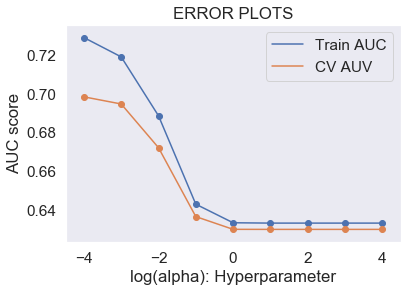

In [ ]:
#plotting the error plots
tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(alpha): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is highest at log_10(alpha) =-4 i.e., <b>alpha = 0.0001</b> and the ideal regularizer is <b>'l1'</b>

Testing the <b> Performance</b>

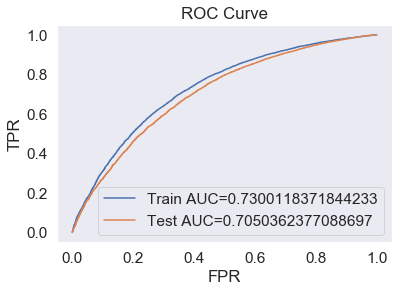

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc

model = SGDClassifier(alpha=0.0001,n_jobs=-1,class_weight='balanced',penalty='l1')
model.fit(new_Xtrain,y_train)
y_train_pred = model.decision_function(new_Xtrain)
y_test_pred = model.decision_function(new_Xtest)

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.705 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.45493849761452015 for threshold -0.515


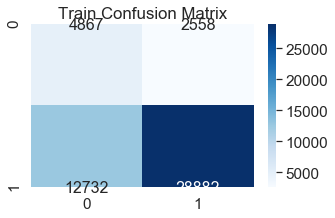

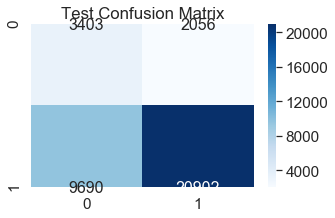

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

### 2.4.4 Applying SVM on SET-4

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,tfidf_w2v_title_train,tfidf_w2v_vectors_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,tfidf_w2v_title_cv,tfidf_w2v_vectors_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,tfidf_w2v_title_test,tfidf_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 701) (49039,)
CV data  (24155, 701) (24155,)
Test data  (36051, 701) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 701)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced'],'penalty':['l1','l2']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                    0.0001],
                          'class_weight': ['balanced'],
                     

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 2.57481273,  1.11962247,  2.53586094,  1.1282266 ,  2.55418658,
         1.14061379,  2.54153442,  1.26794084,  2.54386059,  1.17552177,
         2.86633213,  1.35484974,  3.25006398,  1.87298981,  8.03557968,
         3.29476682, 21.90181589,  6.4028283 ]),
 'std_fit_time': array([7.36434694e-03, 2.74933891e-02, 7.36445933e-03, 4.66848379e-02,
        7.09536360e-03, 7.63215390e-02, 1.43918344e-02, 1.21140421e-01,
        1.69584055e-03, 3.18562699e-02, 1.41042462e-02, 2.66658334e-01,
        4.75088468e-01, 1.26628602e-01, 1.12379824e+00, 1.68363790e-01,
        4.18463616e+00, 6.47137097e-01]),
 'mean_score_time': array([0.05207141, 0.04365516, 0.04686387, 0.04720378, 0.04620973,
        0.0485371 , 0.04753939, 0.05086422, 0.04853686, 0.0482041 ,
        0.04787207, 0.04820514, 0.05152869, 0.05053163, 0.0561835 ,
        0.05851014, 0.04720775, 0.04852748]),
 'std_score_time': array([7.36451553e-03, 9.11173654e-03, 8.77806426e-07, 4.72403096e-04,
        1.

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

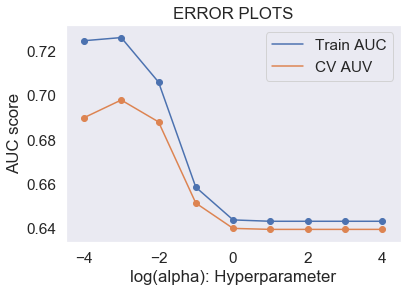

In [ ]:
#plotting the error plots
tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(alpha): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(alpha) = -3 i.e., <b>alpha = 0.001</b> and the ideal regularizer is <b>'l2'</b>

Testing the <b> Performance</b>

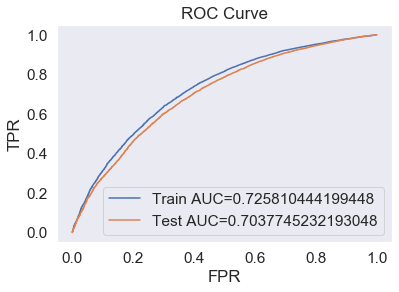

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc

model = SGDClassifier(alpha=0.001,n_jobs=-1,class_weight='balanced',penalty='l2')
model.fit(new_Xtrain,y_train)
y_train_pred = model.decision_function(new_Xtrain)
y_test_pred = model.decision_function(new_Xtest)

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.703 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.44867573865891736 for threshold -0.378


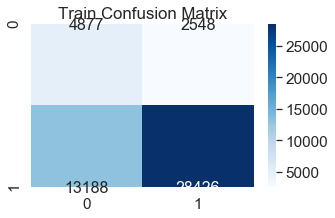

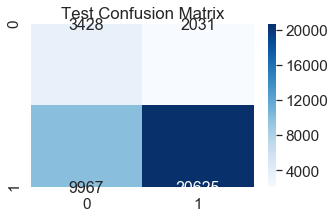

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h2>2.5 SVM with added Features `Sentiment score` </h2>

In [ ]:
Consider these set of features Set 5 :<br>
<B>school_state</B> : categorical data<br>
<B>clean_categories</B> : categorical data<br>
<B>clean_subcategories</B> : categorical data<br>
<B>project_grade_category</B> :categorical data<br>
<B>teacher_prefix</B> : categorical data<br>
<B>quantity</B> : numerical data<br>
<B>teacher_number_of_previously_posted_projects</B> : numerical data<br>
<B>price</B> : numerical data<br>
<B>sentiment score's of each of the essay</B> : numerical data<br>
<B>number of words in the title </B>: numerical data<br>
<B>number of words in the combine essays</B> : numerical data<br>


In [ ]:
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                            0                   0   
1                                            7                   1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay clean_prefix  \
0  My students are English learners that are work...          mrs   
1  Our students arrive to our school eager to lea...           mr   

  clean_grades  price quantity  
0  gradesprek2  154.6       23  
1     grades68  299.0        1  

[2 rows x 22 columns]

In [ ]:
#calculating no of words in the title
num_words_title = []
for i in project_data['project_title']:
    j=i.split()
    tlen = len(j)
    num_words_title.append(tlen)
project_data['num_words_title']=num_words_title

In [ ]:
#calculating the no of words in essay
#https://stackoverflow.com/a/37483537/8488076
num_words_essay = project_data['essay'].str.split().apply(len)
num_words_essay = list(num_words_essay)
project_data['num_words_essay'] = num_words_essay


In [ ]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_is_approved  \
0  \"The limits of your language are the limits o...  ...                   0   
1  The projector we need for our school is very c...  ...                   1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  clean_prefix  \
0  My students are English learners that are work...           mrs   
1  Our students arrive to our school eager to lea...            mr   

  clean_grades  price quantity num_words_title num_words_essay  
0  gradesprek2  154.6       23               7             272  
1     grades68  299.0        1               5             221  

[2 rows x 24 columns]

<b>Calculating sentiment scores</b>

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
sentiment_score = []
for i in project_data['essay']:
    for_sentiment = i;
    ss = sid.polarity_scores(for_sentiment)
    comp_Score = ss['compound']
    sentiment_score.append(comp_Score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
project_data['sentiment_score']=sentiment_score
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  clean_prefix  \
0  My students are English learners that are work...           mrs   
1  Our students arrive to our school eager to lea...            mr   

   clean_grades  price quantity num_words_title num_words_essay  \
0   gradesprek2  154.6       23               7             272   
1      grades68  299.0        1               5             221   

  sentiment_score  
0          0.9611  
1          0.9267  

[2 rows x 25 columns]

<h3> Stratified splitting of data

In [ ]:
project_data.columns
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ...   clean_categories  \
0  \"The limits of your language are the limits o...  ...  Literacy_Language   

  clean_subcategories                                              essay  \
0        ESL Literacy  My students are English learners that are work...   

   clean_prefix clean_grades  price quantity num_words_title num_words_essay  \
0           mrs  gradesprek2  154.6       23               7             272   

   sentiment_score  
0           0.9611  

[1 rows x 24 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h3>Encoding Categorical features

<h4> Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (49039, 5)
Shape of cv matrix after one hot encoding  (24155, 5)
Shape of test matrix after one hot encoding  (36051, 5)
--------------------------------------------------
[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


<h4>  Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (49039, 51)
Shape of cv matrix after one hot encoding  (24155, 51)
Shape of test matrix after one hot encoding  (36051, 51)
--------------------------------------------------
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

####  Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (49039, 4)
Shape of cv matrix after one hot encoding  (24155, 4)
Shape of test matrix after one hot encoding  (36051, 4)
--------------------------------------------------
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]]


#### Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 9)
Shape of cv matrix after one hot encoding  (24155, 9)
Shape of test matrix after one hot encoding  (36051, 9)
--------------------------------------------------
[[0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


####  Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 30)
Shape of cv matrix after one hot encoding  (24155, 30)
Shape of test matrix after one hot encoding  (36051, 30)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 

<H3> Encoding numerical features

####  Encoding 'price' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_cv = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 299.7989451253084, Standard deviation : 369.2416872488041


In [ ]:
print(price_standardized_train[0:5])
print("-"*50)
print(price_standardized_cv[0:5])
print("-"*50)
print(price_standardized_test[0:5])
print("-"*50)

[[-0.24869604]
 [ 2.69525649]
 [-0.07818441]
 [-0.78904673]
 [-0.45817943]]
--------------------------------------------------
[[-0.39645834]
 [-0.38402745]
 [-0.68139366]
 [ 1.10274942]
 [-0.78051573]]
--------------------------------------------------
[[ 0.26990738]
 [-0.78671763]
 [ 0.01343579]
 [ 0.50934405]
 [-0.78758427]]
--------------------------------------------------


#### Encoding 'teacher_number_of_previously_posted_projects' for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


numpro_scalar = StandardScaler()
numpro_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {numpro_scalar.mean_[0]}, Standard deviation : {np.sqrt(numpro_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
numpro_standardized_train = numpro_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_cv = numpro_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
numpro_standardized_test = numpro_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


Mean : 11.151450886029487, Standard deviation : 28.029423272361633


In [ ]:
print(numpro_standardized_train[0:5])
print("-"*50)
print(numpro_standardized_cv[0:5])
print("-"*50)
print(numpro_standardized_test[0:5])
print("-"*50)

[[-0.36217124]
 [-0.39784803]
 [-0.25514085]
 [-0.39784803]
 [-0.39784803]]
--------------------------------------------------
[[ 6.45209669]
 [-0.29081765]
 [-0.21946405]
 [-0.29081765]
 [-0.07675687]]
--------------------------------------------------
[[-0.32649444]
 [-0.36217124]
 [-0.29081765]
 [-0.39784803]
 [-0.39784803]]
--------------------------------------------------


<h4> Encoding Quantity for train, cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


quant_scalar = StandardScaler()
quant_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quant_scalar.mean_[0]}, Standard deviation : {np.sqrt(quant_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quant_standardized_train = quant_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
quant_standardized_cv = quant_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
quant_standardized_test = quant_scalar.transform(X_test['quantity'].values.reshape(-1, 1))


Mean : 17.07910030791819, Standard deviation : 26.33464744141858


In [ ]:
print(quant_standardized_train[0:5])
print("-"*50)
print(quant_standardized_cv[0:5])
print("-"*50)
print(quant_standardized_test[0:5])
print("-"*50)

[[-0.42070433]
 [-0.61056828]
 [-0.45867712]
 [ 0.60456096]
 [ 1.7817174 ]]
--------------------------------------------------
[[-0.15489481]
 [-0.42070433]
 [ 0.64253375]
 [-0.45867712]
 [ 1.62982625]]
--------------------------------------------------
[[-0.61056828]
 [ 0.1488875 ]
 [-0.45867712]
 [ 0.1488875 ]
 [ 0.56658817]]
--------------------------------------------------


<h4>Encoding sentiment_score for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


senti_scalar = StandardScaler()
senti_scalar.fit(X_train['sentiment_score'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {senti_scalar.mean_[0]}, Standard deviation : {np.sqrt(senti_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
senti_standardized_train = senti_scalar.transform(X_train['sentiment_score'].values.reshape(-1, 1))
senti_standardized_cv = senti_scalar.transform(X_cv['sentiment_score'].values.reshape(-1, 1))
senti_standardized_test = senti_scalar.transform(X_test['sentiment_score'].values.reshape(-1, 1))


Mean : 0.9622244764371215, Standard deviation : 0.13892204987038267


In [ ]:
print(senti_standardized_train[0:5])
print("-"*50)
print(senti_standardized_cv[0:5])
print("-"*50)
print(senti_standardized_test[0:5])
print("-"*50)

[[ 0.16466445]
 [ 0.2373671 ]
 [ 0.24096624]
 [-0.32625833]
 [ 0.08980233]]
--------------------------------------------------
[[0.15170755]
 [0.04589281]
 [0.22584985]
 [0.24960417]
 [0.20785414]]
--------------------------------------------------
[[0.15242738]
 [0.24096624]
 [0.24816452]
 [0.15962566]
 [0.00126347]]
--------------------------------------------------


<h4>Encoding num_words_title for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


titlew_scalar = StandardScaler()
titlew_scalar.fit(X_train['num_words_title'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {titlew_scalar.mean_[0]}, Standard deviation : {np.sqrt(titlew_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
titlew_standardized_train = titlew_scalar.transform(X_train['num_words_title'].values.reshape(-1, 1))
titlew_standardized_cv = titlew_scalar.transform(X_cv['num_words_title'].values.reshape(-1, 1))
titlew_standardized_test = titlew_scalar.transform(X_test['num_words_title'].values.reshape(-1, 1))

Mean : 5.14302901772059, Standard deviation : 2.102788951418188


In [ ]:
print(titlew_standardized_train[0:5])
print("-"*50)
print(titlew_standardized_cv[0:5])
print("-"*50)
print(titlew_standardized_test[0:5])
print("-"*50)

[[-0.54357762]
 [ 1.35865798]
 [-0.54357762]
 [-0.54357762]
 [ 0.88309908]]
--------------------------------------------------
[[-1.01913652]
 [ 0.40754018]
 [-0.54357762]
 [-1.49469542]
 [ 0.88309908]]
--------------------------------------------------
[[ 1.35865798]
 [-1.01913652]
 [ 0.40754018]
 [-1.01913652]
 [-0.54357762]]
--------------------------------------------------


<h4>Encoding num_words_essay for train,cv and test

In [ ]:
from sklearn.preprocessing import StandardScaler


essayw_scalar = StandardScaler()
essayw_scalar.fit(X_train['num_words_essay'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {essayw_scalar.mean_[0]}, Standard deviation : {np.sqrt(essayw_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
essayw_standardized_train = essayw_scalar.transform(X_train['num_words_essay'].values.reshape(-1, 1))
essayw_standardized_cv = essayw_scalar.transform(X_cv['num_words_essay'].values.reshape(-1, 1))
essayw_standardized_test = essayw_scalar.transform(X_test['num_words_essay'].values.reshape(-1, 1))

Mean : 255.443646893289, Standard deviation : 65.77941736266241


In [ ]:
print(essayw_standardized_train[0:5])
print("-"*50)
print(essayw_standardized_cv[0:5])
print("-"*50)
print(essayw_standardized_test[0:5])
print("-"*50)

[[-1.01009783]
 [ 1.01181123]
 [ 1.20944144]
 [ 0.02366018]
 [-0.69084903]]
--------------------------------------------------
[[ 1.3158577 ]
 [ 0.20608807]
 [ 2.34961572]
 [ 0.1604811 ]
 [-1.01009783]]
--------------------------------------------------
[[ 1.25504841]
 [-0.43240953]
 [ 0.72296708]
 [-0.35639791]
 [-0.90368157]]
--------------------------------------------------


<h3>Encoding Text Feature(Essay)</h3>

<h5>Performing text pre processing on project_esssays</h5>

In [ ]:
# for train data
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:25<00:00, 1931.08it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:12<00:00, 1948.30it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:18<00:00, 1955.81it/s]


<b>Tfidf Vectorizer</b>

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after tfidf vectorization ",text_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 5000)


In [ ]:
#for cv data
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after tfidf vectorization ",text_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 5000)


In [ ]:
#for test data
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after tfidf vectorization ",text_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 5000)


<b>Performing Dimensionality Reduction using elbow method</b>

In [ ]:
#https://stackoverflow.com/a/48425000/8488076
from sklearn.decomposition import TruncatedSVD

temp_n = [100,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750]
varience = []

for i in temp_n:
    model = TruncatedSVD(n_components = i)
    model.fit(text_tfidf_train)
    temp_variance = model.explained_variance_ratio_.sum()
    varience.append(temp_variance)
    

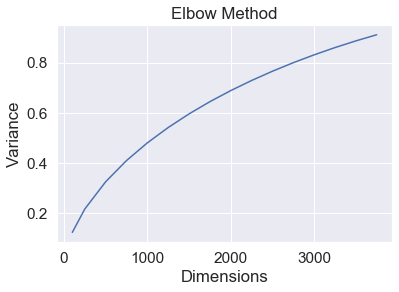

In [ ]:
import matplotlib.pyplot as plt
plt.plot(temp_n,varience)
plt.xlabel("Dimensions")
plt.ylabel("Variance")
plt.title("Elbow Method")
plt.show()

Choosing the optimal number of dimensions to be equal to <b>3500</b> because the variance is nearly 90%

In [ ]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=3500)
model.fit(text_tfidf_train)
text_tfidf_train = model.transform(text_tfidf_train)
text_tfidf_cv = model.transform(text_tfidf_cv)
text_tfidf_test = model.transform(text_tfidf_test)

<h3>Combining the features to form a data matrix</h3>

In [ ]:
from scipy.sparse import hstack
new_Xtrain = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_standardized_train,price_standardized_train,quant_standardized_train,titlew_standardized_train,essayw_standardized_train,senti_standardized_train))
print(new_Xtrain.shape)
print("="*50)
new_Xcv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_standardized_cv,price_standardized_cv,quant_standardized_cv,titlew_standardized_cv,essayw_standardized_cv,senti_standardized_cv))
print(new_Xcv.shape)
print("="*50)
new_Xtest = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_standardized_test,price_standardized_test,quant_standardized_test,titlew_standardized_test,essayw_standardized_test,senti_standardized_test))
print(new_Xtest.shape)

(49039, 105)
(24155, 105)
(36051, 105)


In [ ]:
print("Final Data Matrix")
new_Xtrain = hstack((new_Xtrain,text_tfidf_train))
print(new_Xtrain.shape)
print("="*50)
new_Xcv = hstack((new_Xcv,text_tfidf_cv))
print(new_Xcv.shape)
print("="*50)
new_Xtest = hstack((new_Xtest,text_tfidf_test))
print(new_Xtest.shape)
print("="*50)


Final Data Matrix
(49039, 3605)
(24155, 3605)
(36051, 3605)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 3605)
(73194,)


<b> Performing Hyperparameter Tuning</b>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced'],'penalty':['l1','l2']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(new_Xtrain,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001,
                                    0.0001],
                          'class_weight': ['balanced'],
                     

In [ ]:
model.cv_results_

{'mean_fit_time': array([533.64921379, 256.16230075, 103.38805612,  33.08079306,
         40.78212714,  15.77228427,  32.76314823,  26.83492756,
         26.64504385,  16.37044215,  18.15715035,  17.13139939,
         16.87611373,  31.02399723,  27.58202672,  14.22584407,
         53.60204395,  18.44362354]),
 'std_fit_time': array([  3.9986246 , 190.53746799,  45.38849712,  20.85981303,
         12.82602128,   2.57138163,   7.87096373,   6.78153953,
          8.19876404,   3.59391144,   4.25381355,   5.89140618,
          3.32318666,   4.99408215,   5.03021681,   3.42375376,
          7.00604632,   2.01092974]),
 'mean_score_time': array([5.18640176, 4.82186055, 0.50506584, 3.70226812, 0.53111776,
        1.69230151, 1.37989465, 0.2396675 , 0.75925763, 1.19242207,
        0.27597817, 1.21326701, 0.46345178, 1.61426059, 0.19265588,
        1.90578318, 0.36450768, 1.23927132]),
 'std_score_time': array([3.29177721, 5.67240075, 0.44921061, 0.77613003, 0.20528566,
        1.78904007, 0.97

In [ ]:
#getting the best estimator i.e., the best c value
model.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

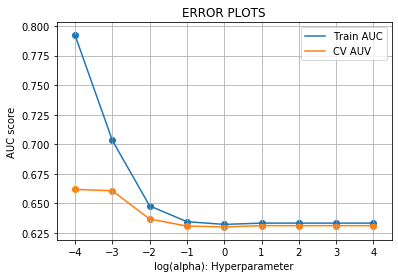

In [ ]:
#plotting the error plots
tuned_parameters = [{'alpha': [10**-x for x in range(-4,5)],'class_weight':['balanced']}]
model = GridSearchCV(SGDClassifier(),tuned_parameters,scoring='roc_auc',n_jobs=-1,cv=3,return_train_score=True)
model.fit(new_Xtrain,y_train)

newC = [np.log10(x) for x in [10**-x for x in range(-4,5)]]
res = model.cv_results_
train_auc = res['mean_train_score']
test_auc = res['mean_test_score']

plt.plot(newC,train_auc,label = "Train AUC")
plt.plot(newC,test_auc,label = "CV AUV")
plt.scatter(newC,train_auc)
plt.scatter(newC,test_auc)
plt.xlabel("log(alpha): Hyperparameter")
plt.ylabel("AUC score")
plt.title("ERROR PLOTS")
plt.legend()
plt.grid()
plt.show()

As we can onserve from the above plot that the AUC score is highest at log_10(c) = -4 i.e., <b>c = 0.0001</b> and the best regularizer is <b>l1</b>

Testing the <b> Performance</b>

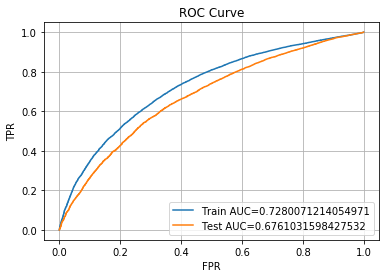

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc


model = SGDClassifier(alpha=0.0001,n_jobs=-1,class_weight='balanced',penalty='l1')
model.fit(new_Xtrain,y_train)
y_train_pred = model.decision_function(new_Xtrain)
y_test_pred = model.decision_function(new_Xtest)

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score for test data is 0.676 which is better than a random model.

Finding <b> Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.4497316608192755 for threshold -0.005


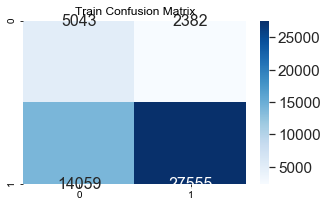

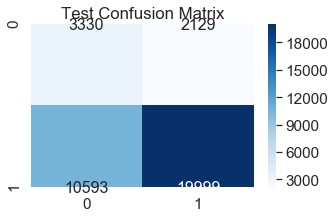

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')



conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h1>3. Conclusion</h1>

In [ ]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Vectorizing Technique","Hyperparameter(alpha)","Regularizer","AUC Score"]
x.add_row(["BOW",0.01,"l2",0.683])
x.add_row(["TFIDF",0.0001,"l1",0.679])
x.add_row(["Avg W2V",0.0001,"l1",0.705])
x.add_row(["TFIDF W2V",0.001,"l2",0.703])
x.add_row(["Set 5",0.0001,"l1",0.676])
print(x)

+-----------------------+-----------------------+-------------+-----------+
| Vectorizing Technique | Hyperparameter(alpha) | Regularizer | AUC Score |
+-----------------------+-----------------------+-------------+-----------+
|          BOW          |          0.01         |      l2     |   0.683   |
|         TFIDF         |         0.0001        |      l1     |   0.679   |
|        Avg W2V        |         0.0001        |      l1     |   0.705   |
|       TFIDF W2V       |         0.001         |      l2     |   0.703   |
|         Set 5         |         0.0001        |      l1     |   0.676   |
+-----------------------+-----------------------+-------------+-----------+


# Part 4: DT

<h1>2. Decision Tree </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [ ]:
print(project_data.columns)
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)


Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'clean_prefix',
       'clean_grades', 'price', 'quantity'],
      dtype='object')


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   

  teacher_number_of_previously_posted_projects   clean_categories  \
0                                            0  Literacy_Language   

  clean_subcategories                                              essay  \
0        ESL Literacy  My students are English learners that are work...   

  clean_prefix clean_grades  price  quantity  
0          mrs  gradesprek2  154.6        23  

[1 rows x 21 columns]

In [ ]:
from sklearn.model_selection import train_test_split
#first splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# now splitting the train data into train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
<h3>2.2.1 Encoding the categorical features</h3>

The categorical features being considered are:
1. teacher_prefix
2. school_state
3. project_grade_category
4. clean_categories
5. clean_sub_categories

<h4> 2.2.1.1 Encoding 'teacher_prefix' in train,cv and test</h4>

In [ ]:
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot_train = vectorizer.transform(X_train['clean_prefix'].values)
teacher_prefix_one_hot_cv = vectorizer.transform(X_cv['clean_prefix'].values)
teacher_prefix_one_hot_test = vectorizer.transform(X_test['clean_prefix'].values)
print("Shape of train matrix after one hot encoding ",teacher_prefix_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",teacher_prefix_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",teacher_prefix_one_hot_test.shape)
print("-"*50)
temp = teacher_prefix_one_hot_train.toarray()
print(temp[0:5])

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of train matrix after one hot encoding  (49039, 5)
Shape of cv matrix after one hot encoding  (24155, 5)
Shape of test matrix after one hot encoding  (36051, 5)
--------------------------------------------------
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


<h4> 2.2.1.2 Encoding 'school_state' in train,cv and test</h4>

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot_train = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
print("Shape of train matrix after one hot encoding ",school_state_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",school_state_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",school_state_one_hot_test.shape)
print("-"*50)
temp = school_state_one_hot_train.toarray()
print(temp[0:5])

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encoding  (49039, 51)
Shape of cv matrix after one hot encoding  (24155, 51)
Shape of test matrix after one hot encoding  (36051, 51)
--------------------------------------------------
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

#### 2.2.1.3 Encoding 'project_grade _category' in train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_grades'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot_train = vectorizer.transform(X_train['clean_grades'].values)
project_grade_one_hot_cv = vectorizer.transform(X_cv['clean_grades'].values)
project_grade_one_hot_test = vectorizer.transform(X_test['clean_grades'].values)
print("Shape of train matrix after one hot encoding ",project_grade_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_grade_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_grade_one_hot_test.shape)
print("-"*50)
temp = project_grade_one_hot_train.toarray()
print(temp[0:5])

['grades35', 'grades68', 'grades912', 'gradesprek2']
Shape of train matrix after one hot encoding  (49039, 4)
Shape of cv matrix after one hot encoding  (24155, 4)
Shape of test matrix after one hot encoding  (36051, 4)
--------------------------------------------------
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


#### 2.2.1.4 Encoding 'project_categories'  for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

project_categories_one_hot_train = vectorizer.transform(X_train['clean_categories'].values)
project_categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
project_categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of train matrix after one hot encoding ",project_categories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_categories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_categories_one_hot_test.shape)
print("-"*50)
temp = project_categories_one_hot_train.toarray()
print(temp[0:5])

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 9)
Shape of cv matrix after one hot encoding  (24155, 9)
Shape of test matrix after one hot encoding  (36051, 9)
--------------------------------------------------
[[0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


#### 2.2.1.5 Encoding 'project_sub_categories' for train,cv and test

In [ ]:
vectorizer = CountVectorizer(lowercase=False,binary=True)
#fitting is done only to train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

project_subcategories_one_hot_train = vectorizer.transform(X_train['clean_subcategories'].values)
project_subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
project_subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of train matrix after one hot encoding ",project_subcategories_one_hot_train.shape)
print("Shape of cv matrix after one hot encoding ",project_subcategories_one_hot_cv.shape)
print("Shape of test matrix after one hot encoding ",project_subcategories_one_hot_test.shape)
print("-"*50)
temp = project_subcategories_one_hot_train.toarray()
print(temp[0:5])

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of train matrix after one hot encoding  (49039, 30)
Shape of cv matrix after one hot encoding  (24155, 30)
Shape of test matrix after one hot encoding  (36051, 30)
--------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 

### 2.2.2 Getting the numerical features

The numerical features considered are:
1. teacher_number_of_previously_posted_projects
2. price

In [ ]:
price_train = X_train["price"].as_matrix().reshape(-1,1)
price_cv = X_cv["price"].as_matrix().reshape(-1,1)
price_test = X_test["price"].as_matrix().reshape(-1,1)

In [ ]:
print(price_train[0:5])
print("-"*50)
print(price_cv[0:5])
print("-"*50)
print(price_test[0:5])
print("-"*50)

[[126.66]
 [131.98]
 [112.97]
 [177.59]
 [  7.9 ]]
--------------------------------------------------
[[184.98]
 [129.9 ]
 [196.64]
 [ 58.75]
 [209.18]]
--------------------------------------------------
[[372.34]
 [159.87]
 [399.94]
 [ 71.01]
 [230.03]]
--------------------------------------------------


In [ ]:
numpro_train = X_train["teacher_number_of_previously_posted_projects"].as_matrix().reshape(-1,1)
numpro_cv = X_cv["teacher_number_of_previously_posted_projects"].as_matrix().reshape(-1,1)
numpro_test = X_test["teacher_number_of_previously_posted_projects"].as_matrix().reshape(-1,1)

In [ ]:
print(numpro_train[0:5])
print("-"*50)
print(numpro_cv[0:5])
print("-"*50)
print(numpro_test[0:5])
print("-"*50)

[[16]
 [ 2]
 [ 3]
 [ 1]
 [11]]
--------------------------------------------------
[[  0]
 [107]
 [ 30]
 [  1]
 [  0]]
--------------------------------------------------
[[19]
 [32]
 [ 1]
 [ 2]
 [ 2]]
--------------------------------------------------


<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
### 2.3.1 Text preprocessing

#### 2.3.1.1 Essays

In [ ]:
# for train data
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:26<00:00, 1870.15it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:12<00:00, 1899.41it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:18<00:00, 1928.28it/s]


#### 2.3.1.2 project_title

In [ ]:
# for test data
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 42093.30it/s]


In [ ]:
#for cv data
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 41900.39it/s]


In [ ]:
#for test data
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 41835.72it/s]


### 2.3.2 Vectorizing Essays

#### 2.3.2.1 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer.transform(preprocessed_essays_train)
print("Shape of matrix after tfidf vectorization ",text_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 5000)


In [ ]:
#for cv data
text_tfidf_cv = vectorizer.transform(preprocessed_essays_cv)
print("Shape of matrix after tfidf vectorization ",text_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 5000)


In [ ]:
#for test data
text_tfidf_test = vectorizer.transform(preprocessed_essays_test)
print("Shape of matrix after tfidf vectorization ",text_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 5000)


#### 2.3.2.2 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49039/49039 [01:30<00:00, 543.27it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_vectors_cv = []; 
for sentence in tqdm(preprocessed_essays_cv): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [00:43<00:00, 553.53it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_vectors_test = []; 
for sentence in tqdm(preprocessed_essays_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36051/36051 [01:06<00:00, 545.24it/s]


36051
300


### 2.3.3 Vectorizing project_titles

#### 2.3.3.1 Tfidf vectorizer

In [ ]:
#for train data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer.transform(preprocessed_titles_train)
print("Shape of matrix after tfidf vectorization ",title_tfidf_train.shape)

Shape of matrix after tfidf vectorization  (49039, 2011)


In [ ]:
#for cv data
title_tfidf_cv = vectorizer.transform(preprocessed_titles_cv)
print("Shape of matrix after tfidf vectorization ",title_tfidf_cv.shape)

Shape of matrix after tfidf vectorization  (24155, 2011)


In [ ]:
#for test data
title_tfidf_test = vectorizer.transform(preprocessed_titles_test)
print("Shape of matrix after tfidf vectorization ",title_tfidf_test.shape)

Shape of matrix after tfidf vectorization  (36051, 2011)


#### 2.3.3.2 Tfidf W2V

In [ ]:
#for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


tfidf_w2v_title_train = []; 
for sentence in tqdm(preprocessed_titles_train): 
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 38014.53it/s]


49039
300


In [ ]:
#for cv data

tfidf_w2v_title_cv = []; 
for sentence in tqdm(preprocessed_titles_cv): 
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 38792.93it/s]


24155
300


In [ ]:
#for test data

tfidf_w2v_title_test = [];
for sentence in tqdm(preprocessed_titles_test):
    vector = np.zeros(300)
    tf_idf_weight =0; 
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 38951.87it/s]


36051
300


<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned below</h2>


I. For set 1 we are using categorical features,numerical features, project_title(tfidf) and project_essay(tfidf)<br>
II. For set 2 we are using categorical features,numerical features, project_title(tfidf W2V) and project_essay(tfidf W2V)<br>

First we are forming the data matrices of train, cv and test by concatinating the individual matrices of categorical and numerical data

In [ ]:
from scipy.sparse import hstack
cat_num_train = hstack((teacher_prefix_one_hot_train,school_state_one_hot_train,project_grade_one_hot_train,project_categories_one_hot_train,project_subcategories_one_hot_train,numpro_train,price_train))
print(cat_num_train.shape)
print("="*50)
cat_num_cv = hstack((teacher_prefix_one_hot_cv,school_state_one_hot_cv,project_grade_one_hot_cv,project_categories_one_hot_cv,project_subcategories_one_hot_cv,numpro_cv,price_cv))
print(cat_num_cv.shape)
print("="*50)
cat_num_test = hstack((teacher_prefix_one_hot_test,school_state_one_hot_test,project_grade_one_hot_test,project_categories_one_hot_test,project_subcategories_one_hot_test,numpro_test,price_test))
print(cat_num_test.shape)

(49039, 101)
(24155, 101)
(36051, 101)


### 2.4.1 Applying Decision Trees on SET-1

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_tfidf_train,text_tfidf_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_tfidf_cv,text_tfidf_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_tfidf_test,text_tfidf_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 7095) (49039,)
CV data  (24155, 7095) (24155,)
Test data  (36051, 7095) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 7095)
(73194,)


<B>Performing Hyperparameter tuning</B>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tuned_parameter = [{"max_depth" : [1,5,10,50] , "min_samples_split" : [5,10,100,500] , "class_weight" : ['balanced']}]
model = GridSearchCV(DecisionTreeClassifier(),tuned_parameter,scoring = "roc_auc",n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'class_weight': ['balanced'],
                          'max_depth': [1, 5, 10, 50],
                          '

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 0.36970592,  0.35929084,  0.35408425,  0.36449711,  1.50248313,
         1.49712372,  1.47445242,  1.45009208,  4.09441113,  3.92496347,
         3.52272916,  3.05165188, 23.04806018, 22.62984467, 18.14438136,
        12.87885404]),
 'std_fit_time': array([0.01948317, 0.01275406, 0.00736373, 0.00736345, 0.03209937,
        0.02248575, 0.02540223, 0.03209937, 0.30667169, 0.29354434,
        0.1952359 , 0.18769689, 0.48987366, 0.29958375, 0.33160863,
        0.56920725]),
 'mean_score_time': array([0.02082888, 0.02082856, 0.01562174, 0.01562166, 0.01562126,
        0.02082785, 0.02082761, 0.01562198, 0.01761961, 0.0182844 ,
        0.01750779, 0.01728678, 0.0209438 , 0.02027957, 0.02027742,
        0.01894943]),
 'std_score_time': array([7.36412217e-03, 7.36400977e-03, 1.12391596e-07, 0.00000000e+00,
        2.24783192e-07, 7.36367259e-03, 7.36316683e-03, 8.99132768e-07,
        4.70696044e-04, 9.39930918e-04, 1.39453346e-03, 4.70021695e-04,
        4.89903609e-

In [ ]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Testing the <b> Performance</b>

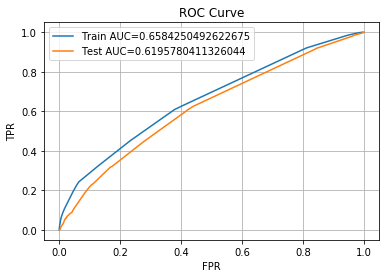

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc

model = DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is <b>0.619</b>

<b> Finding the Confusion Matrix</b>

In [ ]:
#The code is taken from Assignment_SAMPLE_SOLUTION.ipynb by AppliedAI
import numpy as np
import pandas as pd
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.37830644601442887 for threshold 0.52


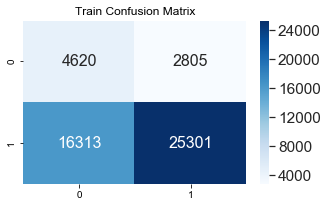

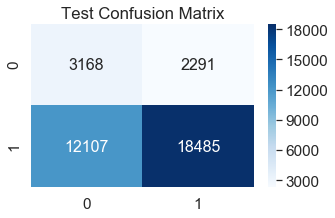

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<b>Getting all the false postive points</b>

In [ ]:
fpr = []
for i in range(len(y_test_pred)):
    if(y_test_pred[i]>=0.5 and y_test[i]==0):
        fpr.append(1)
    else:
        fpr.append(0)

print(fpr[0:10])  

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
final_text = ""


In [ ]:
for i in range(len(fpr)):
    if(fpr[i]==1):
        final_text = final_text + preprocessed_essays_test[i]+" "

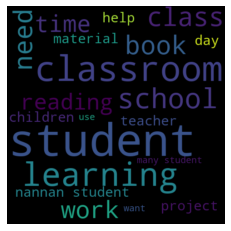

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=480, height=480, max_words=20).generate(final_text) 
  
# plot the WordCloud image  
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 

In [ ]:
import seaborn as sns
import pandas as pd
price_fpr = []
numpro_fpr = []
for i in tqdm(range(0,len(price_test))):
    if fpr[i] == 1:
        price_fpr.append(price_test[i])
        numpro_fpr.append(numpro_test[i])

price_fpr_df = pd.DataFrame(price_fpr,columns=["Price"])
print(price_fpr_df)


100%|███████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 2126467.54it/s]


       Price
0      77.21
1     179.00
2     245.82
3     399.99
4     375.32
...      ...
2286  203.30
2287   78.97
2288    5.25
2289  852.04
2290  269.95

[2291 rows x 1 columns]


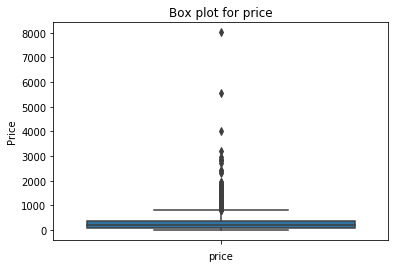

In [ ]:
sns.boxplot(y = "Price",data=price_fpr_df)
plt.title("Box plot for price")
plt.xlabel("price")
plt.show()


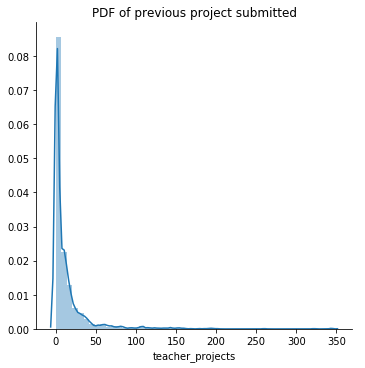

In [ ]:
numpro_fpr_df = pd.DataFrame(numpro_fpr,columns = ['teacher_projects'])
sns.FacetGrid(numpro_fpr_df,size = 5).map(sns.distplot,"teacher_projects").add_legend()
plt.title("PDF of previous project submitted")
plt.show()

### 2.4.2 Applying Decision Trees on SET-2

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,tfidf_w2v_title_train,tfidf_w2v_vectors_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,tfidf_w2v_title_cv,tfidf_w2v_vectors_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,tfidf_w2v_title_test,tfidf_w2v_vectors_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)

Final Data matrix
Train data  (49039, 701) (49039,)
CV data  (24155, 701) (24155,)
Test data  (36051, 701) (36051,)


In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain,new_Xcv]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 701)
(73194,)


<B>Performing Hyperparameter tuning</B>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tuned_parameter = [{"max_depth" : [1,5,10,50] , "min_samples_split" : [5,10,100,500] , "class_weight" : ['balanced']}]
model = GridSearchCV(DecisionTreeClassifier(),tuned_parameter,scoring = "roc_auc",n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'class_weight': ['balanced'],
                          'max_depth': [1, 5, 10, 50],
                          '

In [ ]:
model.cv_results_

{'mean_fit_time': array([  5.37045177,   5.50253765,   5.41307433,   5.56750131,
         24.69199665,  25.61276937,  25.30540379,  23.91801111,
         73.13491376,  72.98129209,  70.17455999,  52.85545381,
        203.53500422, 203.35521603, 159.07581774,  67.73420413]),
 'std_fit_time': array([0.03940031, 0.18189246, 0.15955869, 0.05774131, 0.09958837,
        0.75299353, 0.93787637, 0.22035382, 1.3975344 , 1.26871649,
        1.16462216, 0.48248315, 3.00110445, 4.60395134, 3.06807593,
        1.03777728]),
 'mean_score_time': array([0.12550092, 0.12617135, 0.12383866, 0.13065648, 0.12750014,
        0.13647238, 0.12533712, 0.13231691, 0.12051853, 0.13098892,
        0.12383811, 0.13065537, 0.13049165, 0.1294899 , 0.1205136 ,
        0.11387825]),
 'std_score_time': array([0.00486102, 0.00569956, 0.00245443, 0.00226346, 0.00384708,
        0.01180197, 0.00570456, 0.00696356, 0.00188087, 0.00836452,
        0.00630943, 0.0063238 , 0.00554268, 0.0020901 , 0.0048587 ,
        0.008731

In [ ]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Testing the <b> Performance</b>

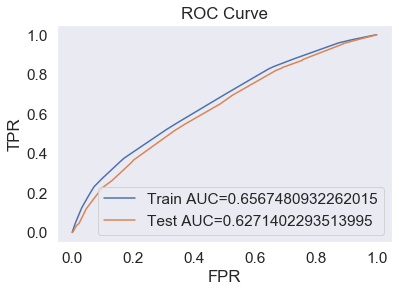

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc

model = DecisionTreeClassifier(max_depth=5,min_samples_split=5,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is <b>0.6271</b>

<b> Finding the Confusion Matrix</b>

the maximum value of tpr*(1-fpr) 0.36316198624556384 for threshold 0.487


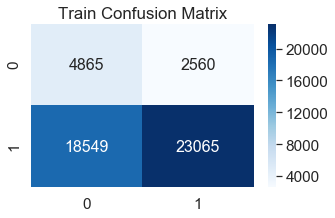

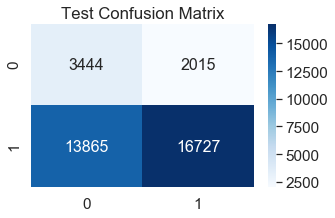

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<b>Getting all the false postive points</b>

In [ ]:
fpr = []
for i in range(len(y_test_pred)):
    if(y_test_pred[i]>=0.5 and y_test[i]==0):
        fpr.append(1)
    else:
        fpr.append(0)

print(fpr[0:10])  

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
final_text = ""


In [ ]:
for i in range(len(fpr)):
    if(fpr[i]==1):
        final_text = final_text + preprocessed_essays_test[i]+" "


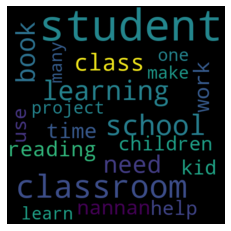

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=480, height=480, max_words=20).generate(final_text) 
  
# plot the WordCloud image  
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 

In [ ]:
import seaborn as sns
import pandas as pd
price_fpr = []
numpro_fpr = []
for i in tqdm(range(0,len(price_test))):
    if fpr[i] == 1:
        price_fpr.append(price_test[i])
        numpro_fpr.append(numpro_test[i])

price_fpr_df = pd.DataFrame(price_fpr,columns=["Price"])





100%|███████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 2255535.64it/s]


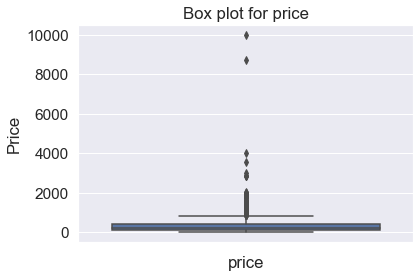

In [ ]:
sns.boxplot(y = "Price",data=price_fpr_df)
plt.title("Box plot for price")
plt.xlabel("price")
plt.show()


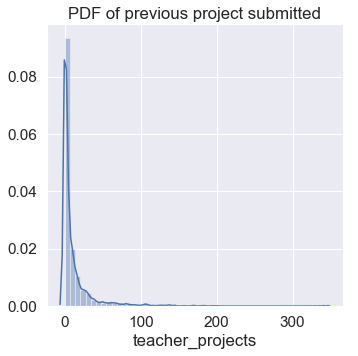

In [ ]:
numpro_fpr_df = pd.DataFrame(numpro_fpr,columns = ['teacher_projects'])
sns.FacetGrid(numpro_fpr_df,size = 5).map(sns.distplot,"teacher_projects").add_legend()
plt.title("PDF of previous project submitted")
plt.show()

<h3>2.4.3 Getting top features using `feature_importances_`</h3>

In [ ]:
print("Final Data matrix")
new_Xtrain = hstack((cat_num_train,title_tfidf_train,text_tfidf_train))
print("Train data ",new_Xtrain.shape,y_train.shape)
print("="*50)
new_Xcv = hstack((cat_num_cv,title_tfidf_cv,text_tfidf_cv))
print("CV data ",new_Xcv.shape,y_cv.shape)
print("="*50)
new_Xtest = hstack((cat_num_test,title_tfidf_test,text_tfidf_test)).tocsr()
print("Test data ",new_Xtest.shape,y_test.shape)
print(type(new_Xtrain))

Final Data matrix
Train data  (49039, 7112) (49039,)
CV data  (24155, 7112) (24155,)
Test data  (36051, 7112) (36051,)
<class 'scipy.sparse.coo.coo_matrix'>


In [ ]:
new_Xtrain = new_Xtrain.tocsr()
new_Xcv = new_Xcv.tocsr()
new_Xtest = new_Xtest.tocsr()

Training the model to find the best features

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc

model = DecisionTreeClassifier(min_samples_split=5,class_weight='balanced')
model.fit(new_Xtrain,y_train)
ft = model.feature_importances_

In [ ]:
print(ft)
ft.shape

[0.00000000e+00 2.19467617e-03 1.79779151e-03 ... 9.07366358e-05
 0.00000000e+00 2.07278912e-04]


(7112,)

In [ ]:
no_of_imp = np.count_nonzero(ft)
print(no_of_imp)

2710


Therefore the number of non zero fields in outr array is 2710. It means that the number of important features is <b>2710</b>

function that selects the top features out of all the features

In [ ]:
#the below code and idea is taken from 
# https://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn
#https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def selectKImportance(model, X, k):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [ ]:
new_Xtrain_best = selectKImportance(model,new_Xtrain, no_of_imp)
new_Xtest_best = selectKImportance(model, new_Xtest, no_of_imp)
new_Xcv_best = selectKImportance(model, new_Xcv, no_of_imp)

In [ ]:
print(new_Xtrain_best.shape)
print("="*50)
print(new_Xcv_best.shape)
print("="*50)
print(new_Xtest_best.shape)
print("="*50)

(49039, 2710)
(24155, 2710)
(36051, 2710)


<h3>2.4.4 Applying Decision Trees on Important features</h3>

<b>Performing Hyperparameter tuning</b>

In [ ]:
#combining the train and cv data matrices because GridSearchCV takes only train data.
from scipy.sparse import vstack
temp_xtrain = vstack([new_Xtrain_best,new_Xcv_best]).tocsr()
temp_ytrain = np.concatenate((y_train,y_cv))
print(temp_xtrain.shape)
print(temp_ytrain.shape)

(73194, 2710)
(73194,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tuned_parameter = [{"max_depth" : [1,5,10,50] , "min_samples_split" : [5,10,100,500] , "class_weight" : ['balanced']}]
model = GridSearchCV(DecisionTreeClassifier(),tuned_parameter,scoring = "roc_auc",n_jobs=-1,cv=3,return_train_score=True)
model.fit(temp_xtrain,temp_ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'class_weight': ['balanced'],
                          'max_depth': [1, 5, 10, 50],
                          '

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 0.25598145,  0.33942564,  0.24667287,  0.24600808,  1.1213359 ,
         1.13047814,  1.17136733,  1.24455929,  3.06230863,  2.85177716,
         2.53383454,  2.14967513, 18.70685887, 19.19959331, 15.00181135,
         9.81930065]),
 'std_fit_time': array([0.009817  , 0.12388487, 0.00329051, 0.00477134, 0.01448296,
        0.00184257, 0.08521096, 0.02246033, 0.0724838 , 0.02870102,
        0.01775057, 0.01578233, 0.6401677 , 1.12565085, 0.7202003 ,
        0.48994893]),
 'mean_score_time': array([0.03590369, 0.03756603, 0.03656904, 0.04055858, 0.04089101,
        0.04266572, 0.04097899, 0.04829899, 0.04089538, 0.04321869,
        0.03906417, 0.03906528, 0.04454764, 0.04305426, 0.04554558,
        0.03956079]),
 'std_score_time': array([0.00081459, 0.00047075, 0.00094027, 0.00600304, 0.00325787,
        0.00591093, 0.00216057, 0.00328819, 0.00247867, 0.0032914 ,
        0.00061962, 0.00084919, 0.00169564, 0.00238997, 0.00729957,
        0.00124362]),
 'param_cl

In [ ]:
model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Testing the <b> Performance</b>

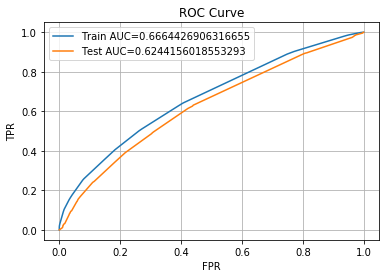

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc

model = DecisionTreeClassifier(max_depth=10,min_samples_split=500,class_weight='balanced')
model.fit(new_Xtrain,y_train)
y_train_pred = model.predict_proba(new_Xtrain)[:,1]
y_test_pred = model.predict_proba(new_Xtest)[:,1]

train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label = "Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label = "Test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

As we can observe from the above plot that the AUC score is <b>0.624</b>

<b> Finding the Confusion Matrix</b>

In [ ]:
#The code is taken from Assignment_SAMPLE_SOLUTION.ipynb by AppliedAI
import numpy as np
import pandas as pd
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.382011039731999 for threshold 0.493


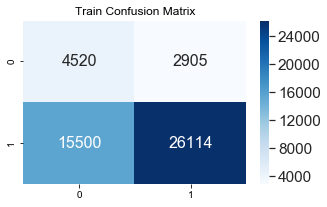

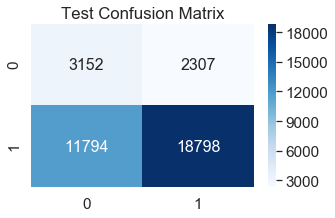

In [ ]:
#https://stackoverflow.com/a/42265865/8488076
#https://stackoverflow.com/a/29648332/8488076
from sklearn.metrics import confusion_matrix
import seaborn as sn


best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

conf_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
df_cm = pd.DataFrame(conf_train, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Train Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt = 'g',cmap='Blues')

conf_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_cm = pd.DataFrame(conf_test, range(2),range(2))
plt.figure(figsize = (5,3))
plt.title("Test Confusion Matrix")
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap='Blues')

<h1>2. Summary</h1>

In [ ]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names = ["Vectorizing Technique","Max Depth","Min Samples Split","AUC Score"]
x.add_row(["TFIDF",10,500,0.6195])
x.add_row(["TFIDF W2V",5,500,0.6271])
x.add_row(["Set 5",10,500,0.624])
print(x)

+-----------------------+-----------+-------------------+-----------+
| Vectorizing Technique | Max Depth | Min Samples Split | AUC Score |
+-----------------------+-----------+-------------------+-----------+
|         TFIDF         |     10    |        500        |   0.6195  |
|       TFIDF W2V       |     5     |        500        |   0.6271  |
|         Set 5         |     10    |        500        |   0.624   |
+-----------------------+-----------+-------------------+-----------+


# Part 5: RF & GBDT

## 2.1 RF and GBDT Set-1

### Merging all Categorical and Numerical  _ SET-1 BOW Encoding

In [ ]:
print(X_train_clean_cat_ohe.shape)
print(X_train_clean_subcat_ohe.shape)
print(X_train_grade_ohe.shape)
print(X_train_state_ohe.shape)
print(X_train_teacher_ohe.shape)
print(train_text_bow.shape)
print(test_text_bow.shape)

(20100, 2)
(20100, 2)
(20100, 2)
(20100, 2)
(20100, 2)
(20100, 8528)
(9900, 8528)


In [ ]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train1 = hstack((X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_teacher_ohe, train_text_bow
                   ,train_title_bow)).tocsr()

X_test1 = hstack((X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_teacher_ohe, test_text_bow
                   ,test_title_bow)).tocsr()

print(X_train1.shape, y_train.shape)
print(X_test1.shape, y_test.shape)
print(type(X_train1))
# train_text_tfidf, train_title_tfidf, train_avg_w2v_vectors, train_title_avg_w2v_vectors,train_essay_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors
#test_text_tfidf, test_title_tfidf, test_avg_w2v_vectors, test_title_avg_w2v_vectors,test_essay_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors

(20100, 9691) (20100,)
(9900, 9691) (9900,)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(X_train1.shape, y_train.shape)

(20100, 9691) (20100,)


## Hyperparameter Tunning GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sea

In [ ]:
RF = RandomForestClassifier()

parameters = {'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc')
classifier.fit(X_train1, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Model Using Best HyperParameter

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

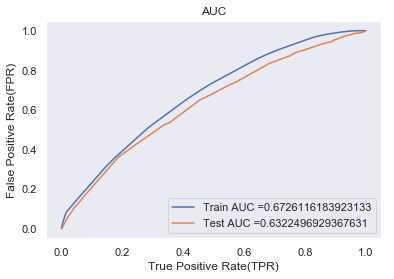

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)

classifier.fit(X_train1, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train1)  
y_test_pred = batch_predict(classifier,X_test1)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### Confusion Matrix for Train and Test Data

In [ ]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.4788768424287167 for threshold 0.902
the maximum value of tpr*(1-fpr) 0.36361669095437693 for threshold 0.914


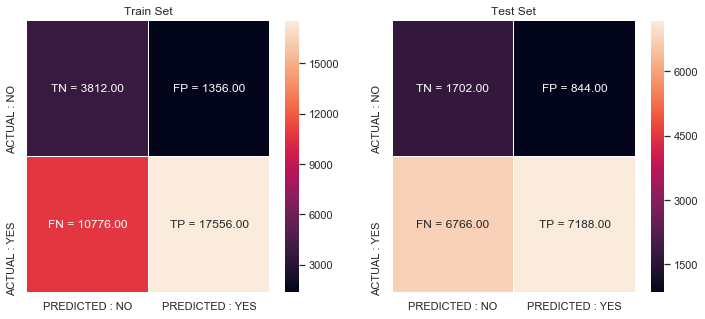

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

## 2.2 Merging all Categorical and Numerical _ SET-2 TF-IDF Encoding

In [ ]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train2 = hstack((X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_teacher_ohe,
                   train_text_tfidf, train_title_tfidf)).tocsr()

X_test2 = hstack((X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_teacher_ohe,
                  test_text_tfidf, test_title_tfidf)).tocsr()

print(X_train2.shape, y_train.shape)
print(X_test2.shape, y_test.shape)
print(type(X_train2))
# train_text_tfidf, train_title_tfidf, train_avg_w2v_vectors, train_title_avg_w2v_vectors,train_essay_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors
#test_text_tfidf, test_title_tfidf, test_avg_w2v_vectors, test_title_avg_w2v_vectors,test_essay_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors

(20100, 9691) (20100,)
(9900, 9691) (9900,)
<class 'scipy.sparse.csr.csr_matrix'>


### Hyperparameter Tunning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
RF = RandomForestClassifier()

parameters = {'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc')
classifier.fit(X_train2, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Model using best Hyperparameter

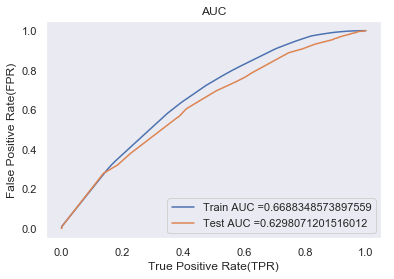

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)

classifier.fit(X_train2, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train2)  
y_test_pred = batch_predict(classifier,X_test2)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### Confusion Matrix For Train & Test Data

the maximum value of tpr*(1-fpr) 0.5174641982787899 for threshold 0.921
the maximum value of tpr*(1-fpr) 0.34512947997353216 for threshold 0.92


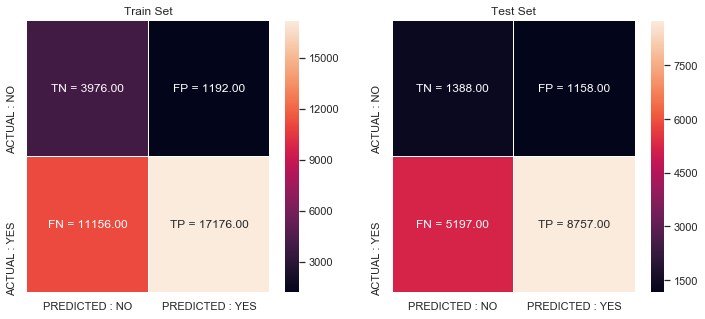

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

## 2.3 Merging all Categorical and Numerical _ SET-3 AVG-W2V Encoding

In [ ]:
X_train3 = hstack((X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_teacher_ohe,
                   train_avg_w2v_vectors, train_title_avg_w2v_vectors)).tocsr()

X_test3 = hstack((X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_teacher_ohe,
                  test_avg_w2v_vectors, test_title_avg_w2v_vectors)).tocsr()

print(X_train3.shape, y_train.shape)
print(X_test3.shape, y_test.shape)
print(type(X_train3))
# train_text_tfidf, train_title_tfidf, train_avg_w2v_vectors, train_title_avg_w2v_vectors,train_essay_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors
#test_text_tfidf, test_title_tfidf, test_avg_w2v_vectors, test_title_avg_w2v_vectors,test_essay_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors

(20100, 610) (20100,)
(9900, 610) (9900,)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(X_train3.shape, y_train.shape)

(20100, 610) (20100,)


### Hyperparameter Tunning

In [ ]:
RF = RandomForestClassifier()

parameters = {'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc')
classifier.fit(X_train3, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Model Using Hyperparameter

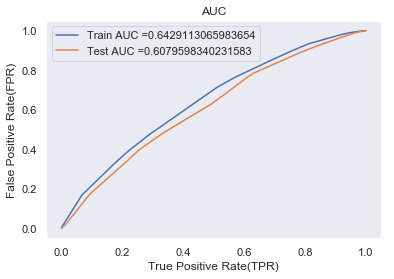

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500)

classifier.fit(X_train3, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train3)  
y_test_pred = batch_predict(classifier,X_test3)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### Train & Test Confusion Matrix

the maximum value of tpr*(1-fpr) 0.35700334632392833 for threshold 0.855
the maximum value of tpr*(1-fpr) 0.32063718281625825 for threshold 0.855


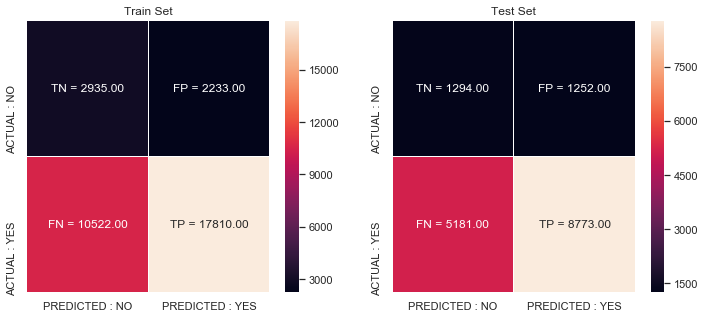

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

## 2.4 Merging all Categorical and Numerical _ SET-4 TFIDF-W2V Encoding

In [ ]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train4 = hstack((X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_teacher_ohe,
                   train_essay_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors)).tocsr()

X_test4 = hstack((X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_teacher_ohe,
                  test_essay_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors)).tocsr()

print(X_train4.shape, y_train.shape)
print(X_test4.shape, y_test.shape)
print(type(X_train2))
# train_text_tfidf, train_title_tfidf, train_avg_w2v_vectors, train_title_avg_w2v_vectors,train_essay_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors
#test_text_tfidf, test_title_tfidf, test_avg_w2v_vectors, test_title_avg_w2v_vectors,test_essay_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors

(20100, 610) (20100,)
(9900, 610) (9900,)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(X_train4.shape, y_train.shape)

(20100, 610) (20100,)


### Hyperparameter Tunning

In [ ]:
RF = RandomForestClassifier()

parameters = {'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500, 1000, 1250]}

classifier = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc')
classifier.fit(X_train4, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500, 1000, 1250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Model using Best Hyperparameter

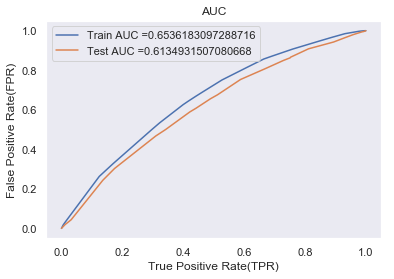

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500)

classifier.fit(X_train4, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train4)  
y_test_pred = batch_predict(classifier,X_test4)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### Train & Test Confusion Matrix

the maximum value of tpr*(1-fpr) 0.37570050646710457 for threshold 0.879
the maximum value of tpr*(1-fpr) 0.34062407499627606 for threshold 0.851


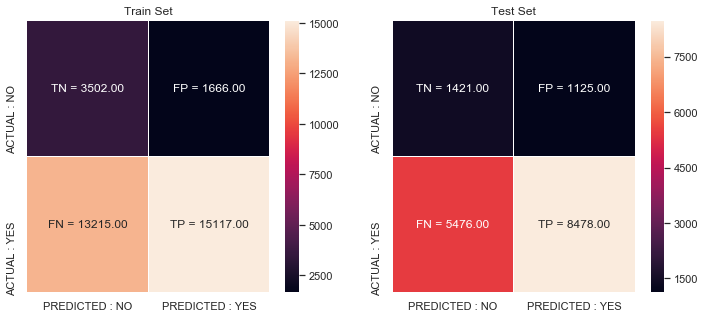

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

## 2.5 Apply Gradient Boosted Decision Trees (GBDT)

<b> Applying Gradient Boosted Decision Tree on same sets again to verify which algo is performing better, we need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3 </b> </br>


### 2.5.1 Applying GBDT on Set - 1

In [ ]:
print(X_train1.shape, y_train.shape)

(20100, 9691) (20100,)


### Hyperparameter Tunning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
GBDT = GradientBoostingClassifier()

parameters = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier = GridSearchCV(GBDT, parameters, cv=3, scoring = 'roc_auc')
classifier.fit(X_train1, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 25, 50, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Using Best Hyperparameter

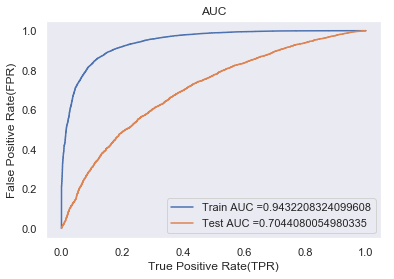

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth = 5 , min_samples_split = 250)

classifier.fit(X_train1, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train1)
y_test_pred = batch_predict(classifier,X_test1)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

### Confusion Matrix

the maximum value of tpr*(1-fpr) 0.7586193479766012 for threshold 0.808
the maximum value of tpr*(1-fpr) 0.425603832860771 for threshold 0.86


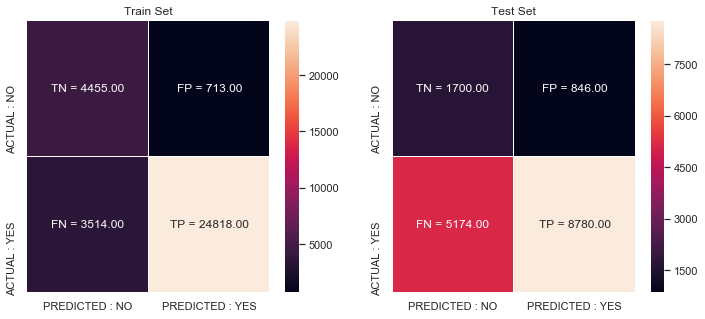

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

### 2.5.2 Applying GBDT on Set - 2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
print(X_train2.shape, y_train.shape)

(20100, 9691) (20100,)


### HyperParameter Tunning

In [ ]:
GBDT = GradientBoostingClassifier()

parameters = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier = GridSearchCV(GBDT, parameters, cv=3, scoring = 'roc_auc')
classifier.fit(X_train2, y_train)                                         

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 25, 50, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Using Best Hyperparameters 

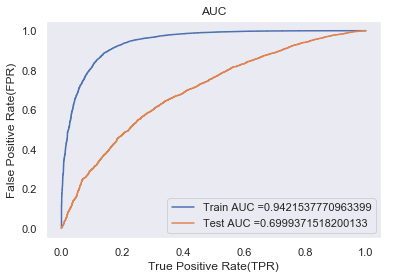

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth = 10 , min_samples_split = 250)

classifier.fit(X_train2, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train2)
y_test_pred = batch_predict(classifier,X_test2)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()
                                        

### Train and Test Confusion Matrix

the maximum value of tpr*(1-fpr) 0.7628652361823036 for threshold 0.841
the maximum value of tpr*(1-fpr) 0.4244734776064234 for threshold 0.85


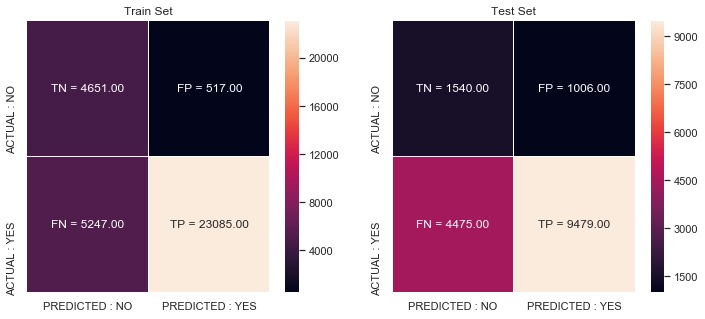

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

### 2.5.3  Applying GBDT on Set - 3

In [ ]:
print(X_train3.shape, y_train.shape)

(20100, 610) (20100,)


### HyperParameter Tunning

In [ ]:
GBDT = GradientBoostingClassifier()

parameters = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier = GridSearchCV(GBDT, parameters, cv=3, scoring = 'roc_auc')
classifier.fit(X_train3, y_train)                                         

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 25, 50, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Using Best Hyperparameter

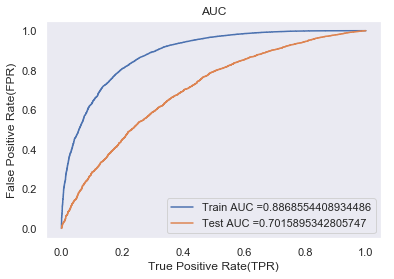

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth = 5 , min_samples_split = 50)

classifier.fit(X_train3, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train3)
y_test_pred = batch_predict(classifier,X_test3)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()
                                        

### Train and Test Confusion Matrix

the maximum value of tpr*(1-fpr) 0.6466596697976098 for threshold 0.85
the maximum value of tpr*(1-fpr) 0.4226376847460082 for threshold 0.863


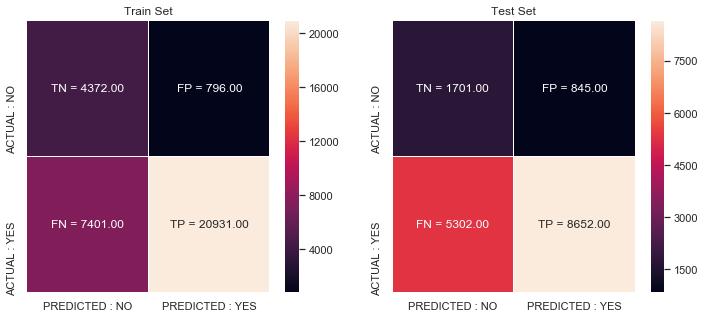

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

### 2.5.4 Applying GBDT on Set - 4

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
print(X_train4.shape, y_train.shape)

(20100, 610) (20100,)


### HyperParameter Tunning

In [ ]:
GBDT = GradientBoostingClassifier()

parameters = {'max_depth' : [5, 10, 20, 50, 100], 'n_estimators' : [10, 25, 50, 100, 250]}

classifier = GridSearchCV(GBDT, parameters, cv=3, scoring = 'roc_auc')
classifier.fit(X_train4, y_train)                                         

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 25, 50, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Training Using Best Hyperparameter

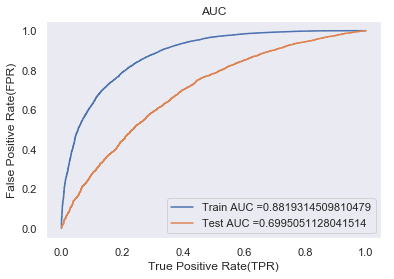

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(max_depth = 5 , min_samples_split = 100)

classifier.fit(X_train4, y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train4)
y_test_pred = batch_predict(classifier,X_test4)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()
                                        

### Train and Test Confusion Matrix

the maximum value of tpr*(1-fpr) 0.6345110308050191 for threshold 0.836
the maximum value of tpr*(1-fpr) 0.42250657276894876 for threshold 0.86


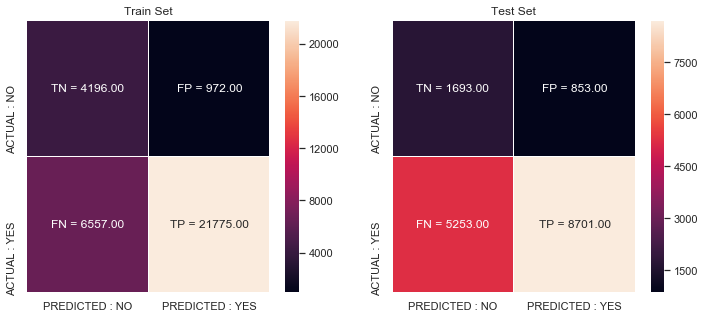

In [ ]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns
sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

<h1>3. Conclusion</h1>

In [ ]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
TB = PrettyTable()

TB.field_names = ["Rand_Forest - MODEL", "HyperparameterS", "Train_AUC", "Test_Auc"]
TB.title = "Decision Tree"
TB.add_row(["BOW-ENC-RF", "Depth:10  | Samp_Split:250", 0.67,0.63])
TB.add_row(["TFIDF-ENC-RF", "Depth:10  | Samp_Split:250", 0.66, 0.62])
TB.add_row(["AvgW2V-ENC-RF", "Depth:5   | Samp_Split:500", 0.64, 0.60])
TB.add_row(["Tf-Idf-ENC-RF", "Depth:5   | Samp_Split:250", 0.65, 0.61])
print(TB)

TB1 = PrettyTable()

TB1.field_names = ["GBDT - MODEL", "HyperparameterS", "Train_AUC", "Test_Auc"]
TB1.title = "Gradient Boosting Decision Tree"
TB1.add_row(["BOW-ENC-GBDT", "Depth:5   | Samp_Split:250", 0.94,0.71])
TB1.add_row(["TFIDF-ENC-GBDT", "Depth:10  | Samp_Split:250", 0.92, 0.68])
TB1.add_row(["AvgW2V-ENC-GBDT", "Depth:5   | Samp_Split:50", 0.88, 0.67])
TB1.add_row(["Tf-Idf-ENC-GBDT", "Depth:5   | Samp_Split:100", 0.88, 0.69])
print(TB1)

+---------------------+----------------------------+-----------+----------+
| Rand_Forest - MODEL |      HyperparameterS       | Train_AUC | Test_Auc |
+---------------------+----------------------------+-----------+----------+
|      BOW-ENC-RF     | Depth:10  | Samp_Split:250 |    0.67   |   0.63   |
|     TFIDF-ENC-RF    | Depth:10  | Samp_Split:250 |    0.66   |   0.62   |
|    AvgW2V-ENC-RF    | Depth:5   | Samp_Split:500 |    0.64   |   0.6    |
|    Tf-Idf-ENC-RF    | Depth:5   | Samp_Split:250 |    0.65   |   0.61   |
+---------------------+----------------------------+-----------+----------+
+-----------------+----------------------------+-----------+----------+
|   GBDT - MODEL  |      HyperparameterS       | Train_AUC | Test_Auc |
+-----------------+----------------------------+-----------+----------+
|   BOW-ENC-GBDT  | Depth:5   | Samp_Split:250 |    0.94   |   0.71   |
|  TFIDF-ENC-GBDT | Depth:10  | Samp_Split:250 |    0.92   |   0.68   |
| AvgW2V-ENC-GBDT | Depth:5   | 

<b>Observations:</b> </br> 

1. From Above we can say that GBDT performs better compare to Random Forest models. Among them BOW encoded models will perform better, Since BOW is High dimensional compared to others.
2. As GridSearch for GBDT is Taking So much time i have taken 30K points as suggested. For those points the Random Forest and Gradient Boosting Decision Tree both performed well on BOW encoded features.

# FINAL CONCLUSIONS

In [ ]:
from prettytable import PrettyTable
TB = PrettyTable()

TB.field_names = ["MODEL", "ENCODING", "AUC-SCORE"]
TB.add_row(["K NEAREST NEIGH.", "TFIDF-W2V",0.633])
TB.add_row(["LOGISTIC REGRESSION", "TFIDF-W2V" ,0.698])
TB.add_row(["SUPPORT VECTOR MACHINE", "AVG-W2V",0.705])
TB.add_row(["DECISION TREES", "TFIDF-W2V", 0.627])
TB.add_row(["RANDOM FORESTS", "BOW", 0.63])
TB.add_row(["GRADIENT BOOSTED DECISION TREES", "BOW", 0.71])
print(TB)

+---------------------------------+-----------+-----------+
|              MODEL              |  ENCODING | AUC-SCORE |
+---------------------------------+-----------+-----------+
|         K NEAREST NEIGH.        | TFIDF-W2V |   0.633   |
|       LOGISTIC REGRESSION       | TFIDF-W2V |   0.698   |
|      SUPPORT VECTOR MACHINE     |  AVG-W2V  |   0.705   |
|          DECISION TREES         | TFIDF-W2V |   0.627   |
|          RANDOM FORESTS         |    BOW    |    0.63   |
| GRADIENT BOOSTED DECISION TREES |    BOW    |    0.71   |
+---------------------------------+-----------+-----------+
